In [1]:
import json
import nglview
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from pymatgen.core import Structure


plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)


def read_json_structures(root: Path) -> pd.DataFrame:
    return pd.DataFrame([
        {'_id': path.name.strip('.json'), 'structure': Structure.from_dict(json.load(open(path)))}
        for path in tqdm(root.glob('*.json'))
    ])

/Users/tomatoparetogmail.com/Desktop/Github/idao_22/env/lib/python3.8/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/Users/tomatoparetogmail.com/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [2]:
models = {
    'jv_optb88vdw_bandgap_alignn_train.json': 1,
    'mp_gappbe_alignnn_train.json': 2,
    'jv_mbj_bandgap_alignn_train.json': 3,
    'qm9_gap_alignn_train.json': 4
    }

num_to_models = {value: key.strip('.json') for key, value in models.items()}

df = pd.read_csv('eda_data/train_preds.csv').rename(models, axis=1).set_index('_id')
df.head()

,band_gap,1,2,3,4
_id,,,,,
6141cf0f51c1cbd9654b8870,1.08430,1.09866,1.07821,1.08270,1.07917
6141cf1051c1cbd9654b8872,1.11020,1.11272,1.09761,1.10577,1.10256
6141cf11cc0e69a0cf28ab35,1.14840,1.16076,1.14597,1.15386,1.14894
6141cf11b842c2e72e2f2d48,1.80680,1.81770,1.80637,1.81719,1.81296
6141cf11ae4fb853db2e3f14,0.36000,0.35926,0.36050,0.35076,0.36063


### Анализ остатков предсказания

Метрика качества с лб:
$$ \frac{1}{n}\sum_{i=1}^{n} \left[|\hat{y} - y | < 0.02 \right]$$
То есть мы хотим, чтобы отклонение по модулю от реального значения энергии было минимальным и не превышало $0.02$. 

Как выглядят модули остатков для разных датасетов?

In [3]:
residuals = df.iloc[:, 1:].subtract(df['band_gap'], axis=0)
root_public_path = Path('../data/dichalcogenides_public')
root_private_path = Path('../data/dichalcogenides_private')

df_private = read_json_structures(root_private_path / 'structures')
df_public = read_json_structures(
    root_public_path / 'structures'
).merge(pd.read_csv(root_public_path / 'targets.csv'))


# понадобится дальше
df_public['formula'] = df_public['structure'].apply(lambda x: x.formula)
df_private['formula'] = df_private['structure'].apply(lambda x: x.formula)

public = pd.concat([df_public.set_index('_id'), (residuals)], axis=1)
show = lambda id_: nglview.show_pymatgen(public.loc[id_, 'structure'])
residuals.abs().describe()

,1,2,3,4
count,2966.00000,2966.00000,2966.00000,2966.00000
mean,0.00464,0.00350,0.00647,0.00346
std,0.00852,0.00810,0.00859,0.00789
min,0.00000,0.00000,0.00000,0.00000
25%,0.00149,0.00083,0.00188,0.00085
50%,0.00295,0.00184,0.00444,0.00180
75%,0.00502,0.00328,0.00783,0.00334
max,0.18673,0.19231,0.16415,0.21868


In [159]:
residuals.corr()

,1,2,3,4
1,1.00000,0.80448,0.77952,0.78620
2,0.80448,1.00000,0.62098,0.75276
3,0.77952,0.62098,1.00000,0.66893
4,0.78620,0.75276,0.66893,1.00000


#### Анализ неправильных предсказаний

Какая модель ошибалась больше всего?

In [4]:
problematic_ids = residuals.where(residuals.abs() > 0.02).dropna(axis=0, how='all')
problematic_ids.count()

1     82
2     81
3    127
4     72
dtype: int64

**Вывод:** третья модель (jv_mbj_bandgap_alignn_train) допускает больше всего критических ошибок

Как распределены ошибки предсказаний для каждой из модели?

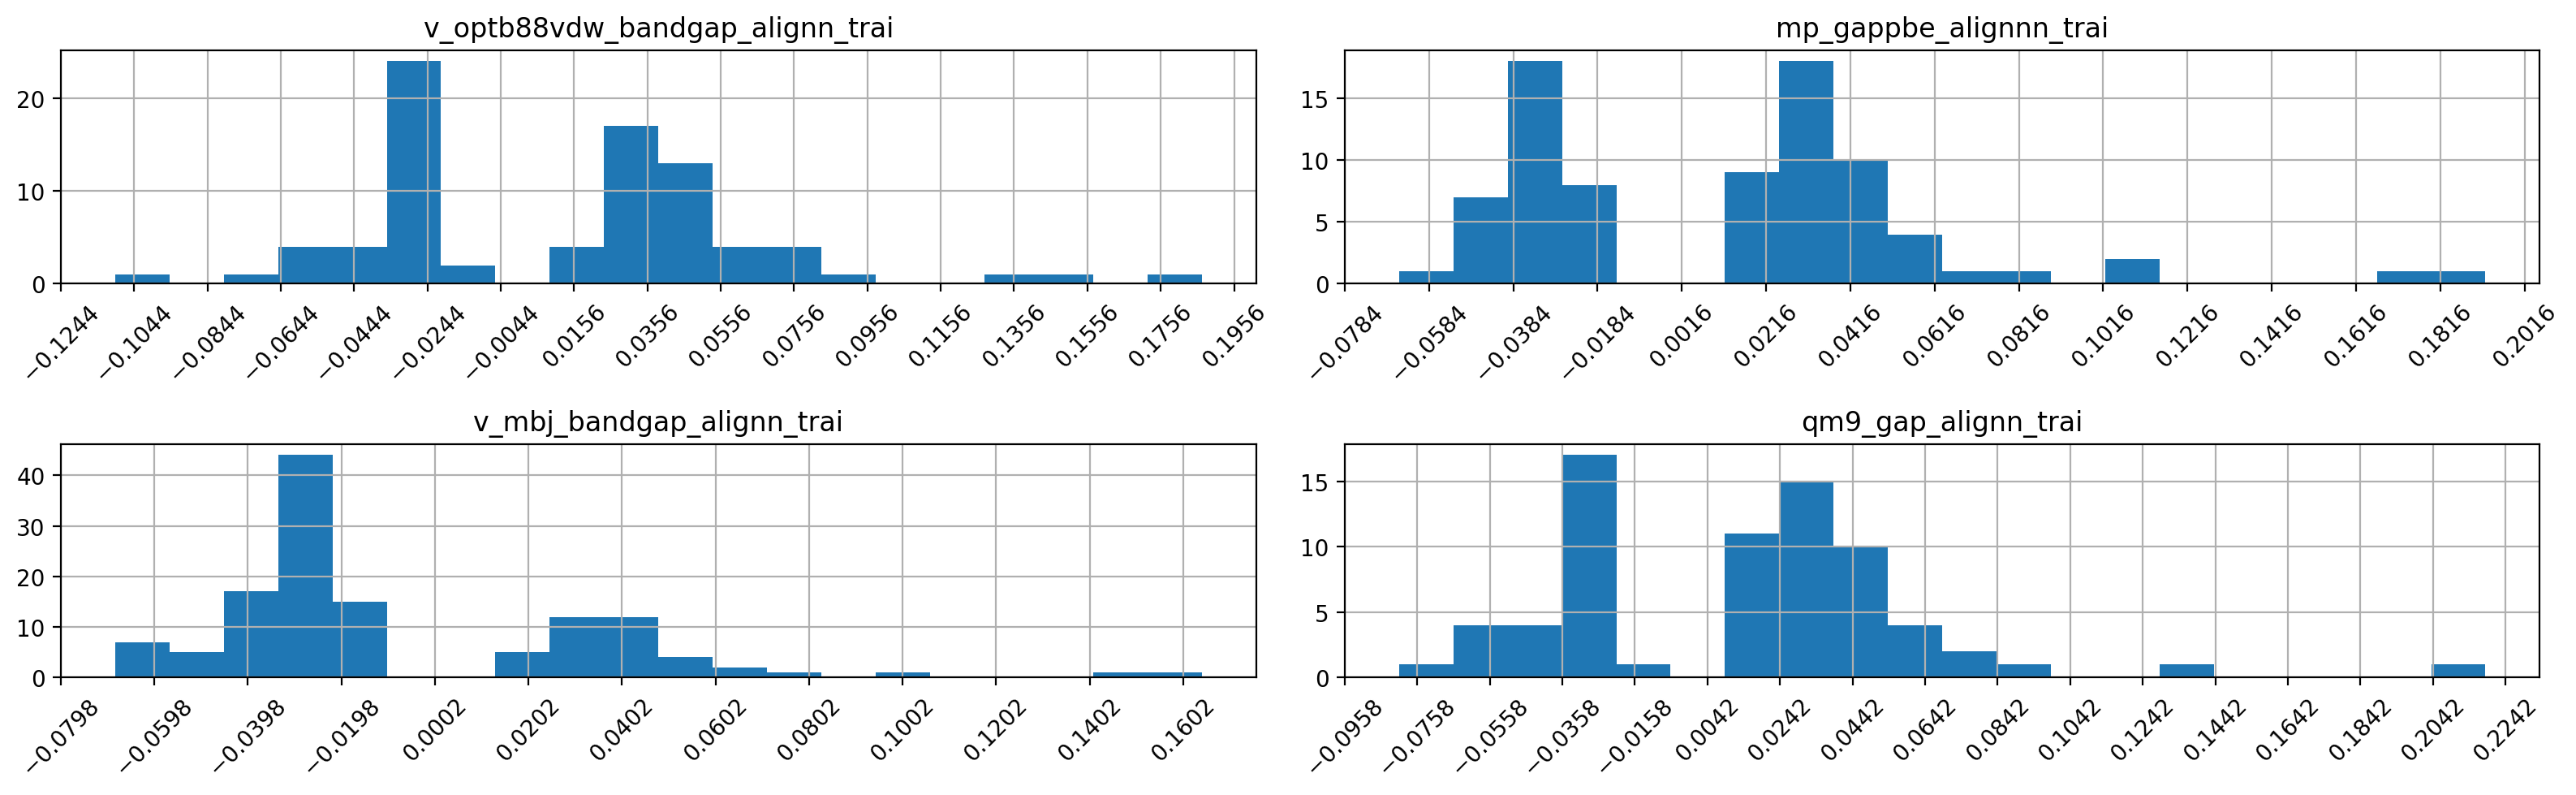

In [5]:
hist_stepsize = 0.02
axes_row = problematic_ids.hist(bins=20, xrot=45, grid=True, layout=(2, 2))

for row in axes_row:
    for ax in row:
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, hist_stepsize))
        ax.set_title(num_to_models[int(ax.axes.title.get_text())])

plt.tight_layout()


Сколько было случаев, когда одновременно ошибалось 4, 3, 2 и 1 модель одновременно?

In [6]:
problematic_ids.count(axis=1).value_counts().sort_index(ascending=False)

4    40
3    30
2    28
1    56
dtype: int64

Как предикшены соотносятся с реальными данными в разрезе по моделям?

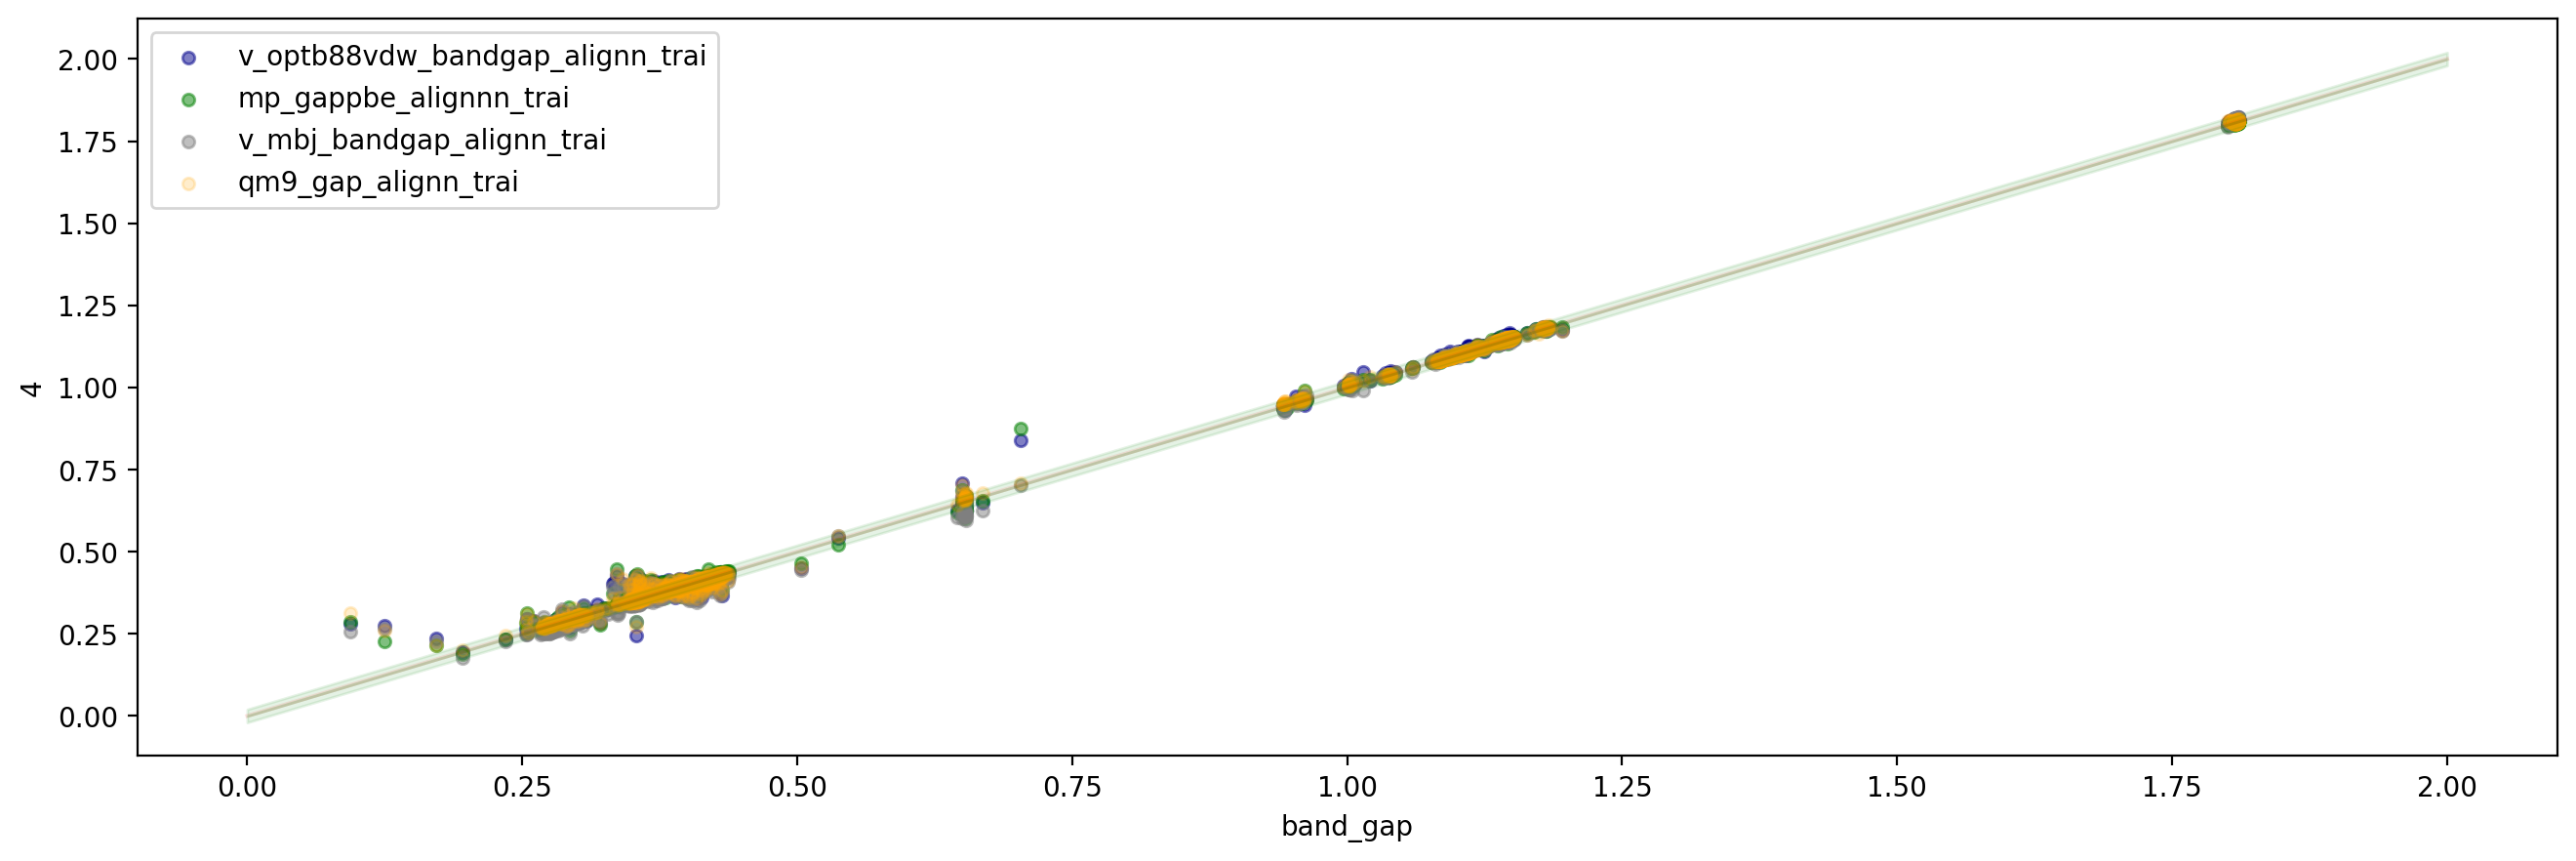

In [148]:
ax = df.plot(kind='scatter', x='band_gap', y=1, label=num_to_models[1], color='DarkBlue', alpha=0.5)
ax.plot([0,2], [0,2], color='red', alpha=0.1, label='IDEAL');
df.plot(kind='scatter', x='band_gap', y=2, label=num_to_models[2], ax=ax, color='green', alpha=0.5)
df.plot(kind='scatter', x='band_gap', y=3, label=num_to_models[3], ax=ax, color='grey', alpha=0.5)
df.plot(kind='scatter', x='band_gap', y=4, label=num_to_models[4], ax=ax, color='orange', alpha=0.2);
ax.fill_between([0, 2], [0, 2.0], [0.02, 2.02], alpha=0.1, color='green')
ax.fill_between([0, 2], [0, 2.0], [-0.02, 1.98], alpha=0.1, color='green');

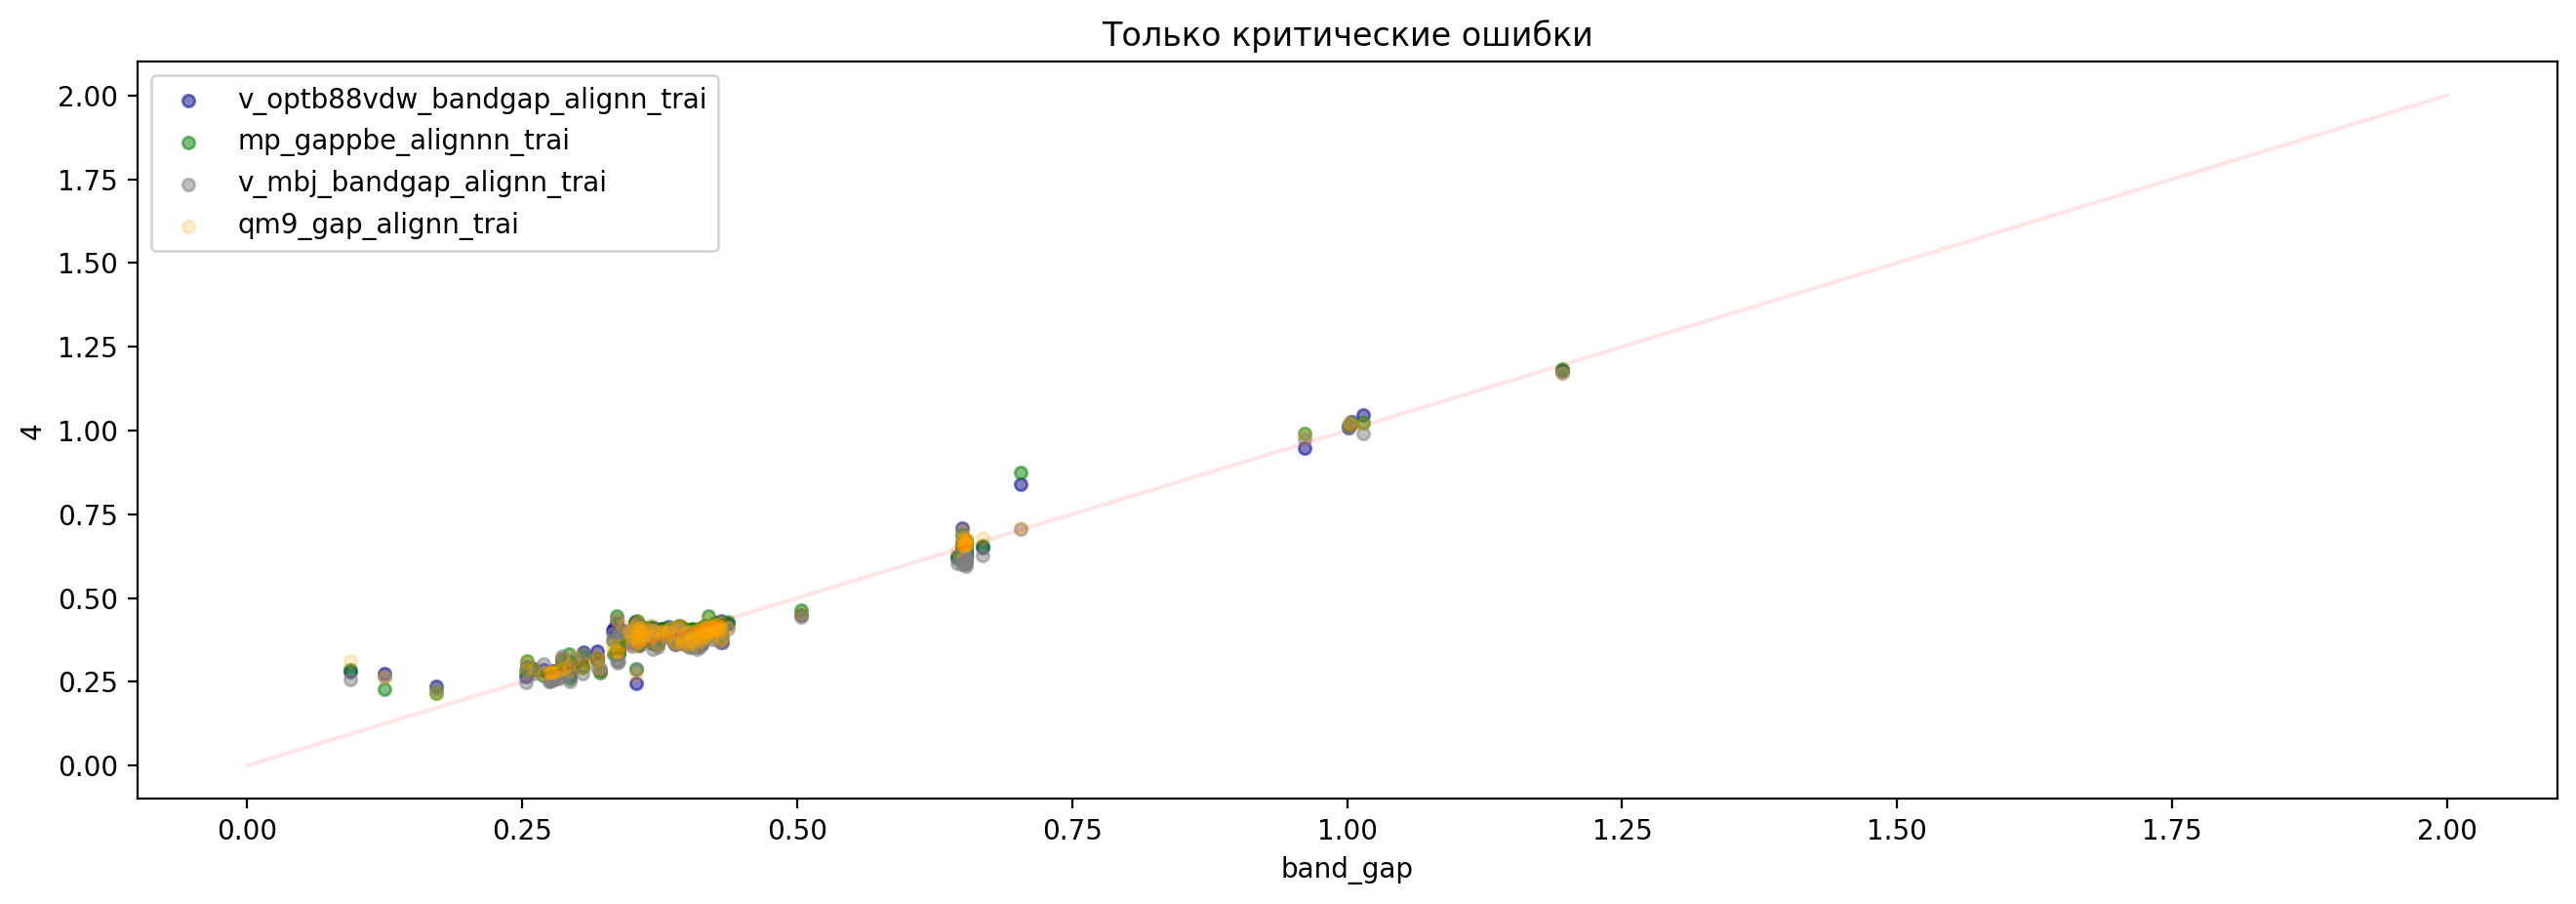

In [154]:
temp_ = df.loc[problematic_ids.index, :]
ax = temp_.plot(kind='scatter', x='band_gap', y=1, label=num_to_models[1], color='DarkBlue', alpha=0.5)
ax.plot([0,2], [0,2], color='red', alpha=0.1, label='IDEAL');
ax.set_title('Только критические ошибки')
temp_.plot(kind='scatter', x='band_gap', y=2, label=num_to_models[2], ax=ax, color='green', alpha=0.5)
temp_.plot(kind='scatter', x='band_gap', y=3, label=num_to_models[3], ax=ax, color='grey', alpha=0.5)
temp_.plot(kind='scatter', x='band_gap', y=4, label=num_to_models[4], ax=ax, color='orange', alpha=0.2);

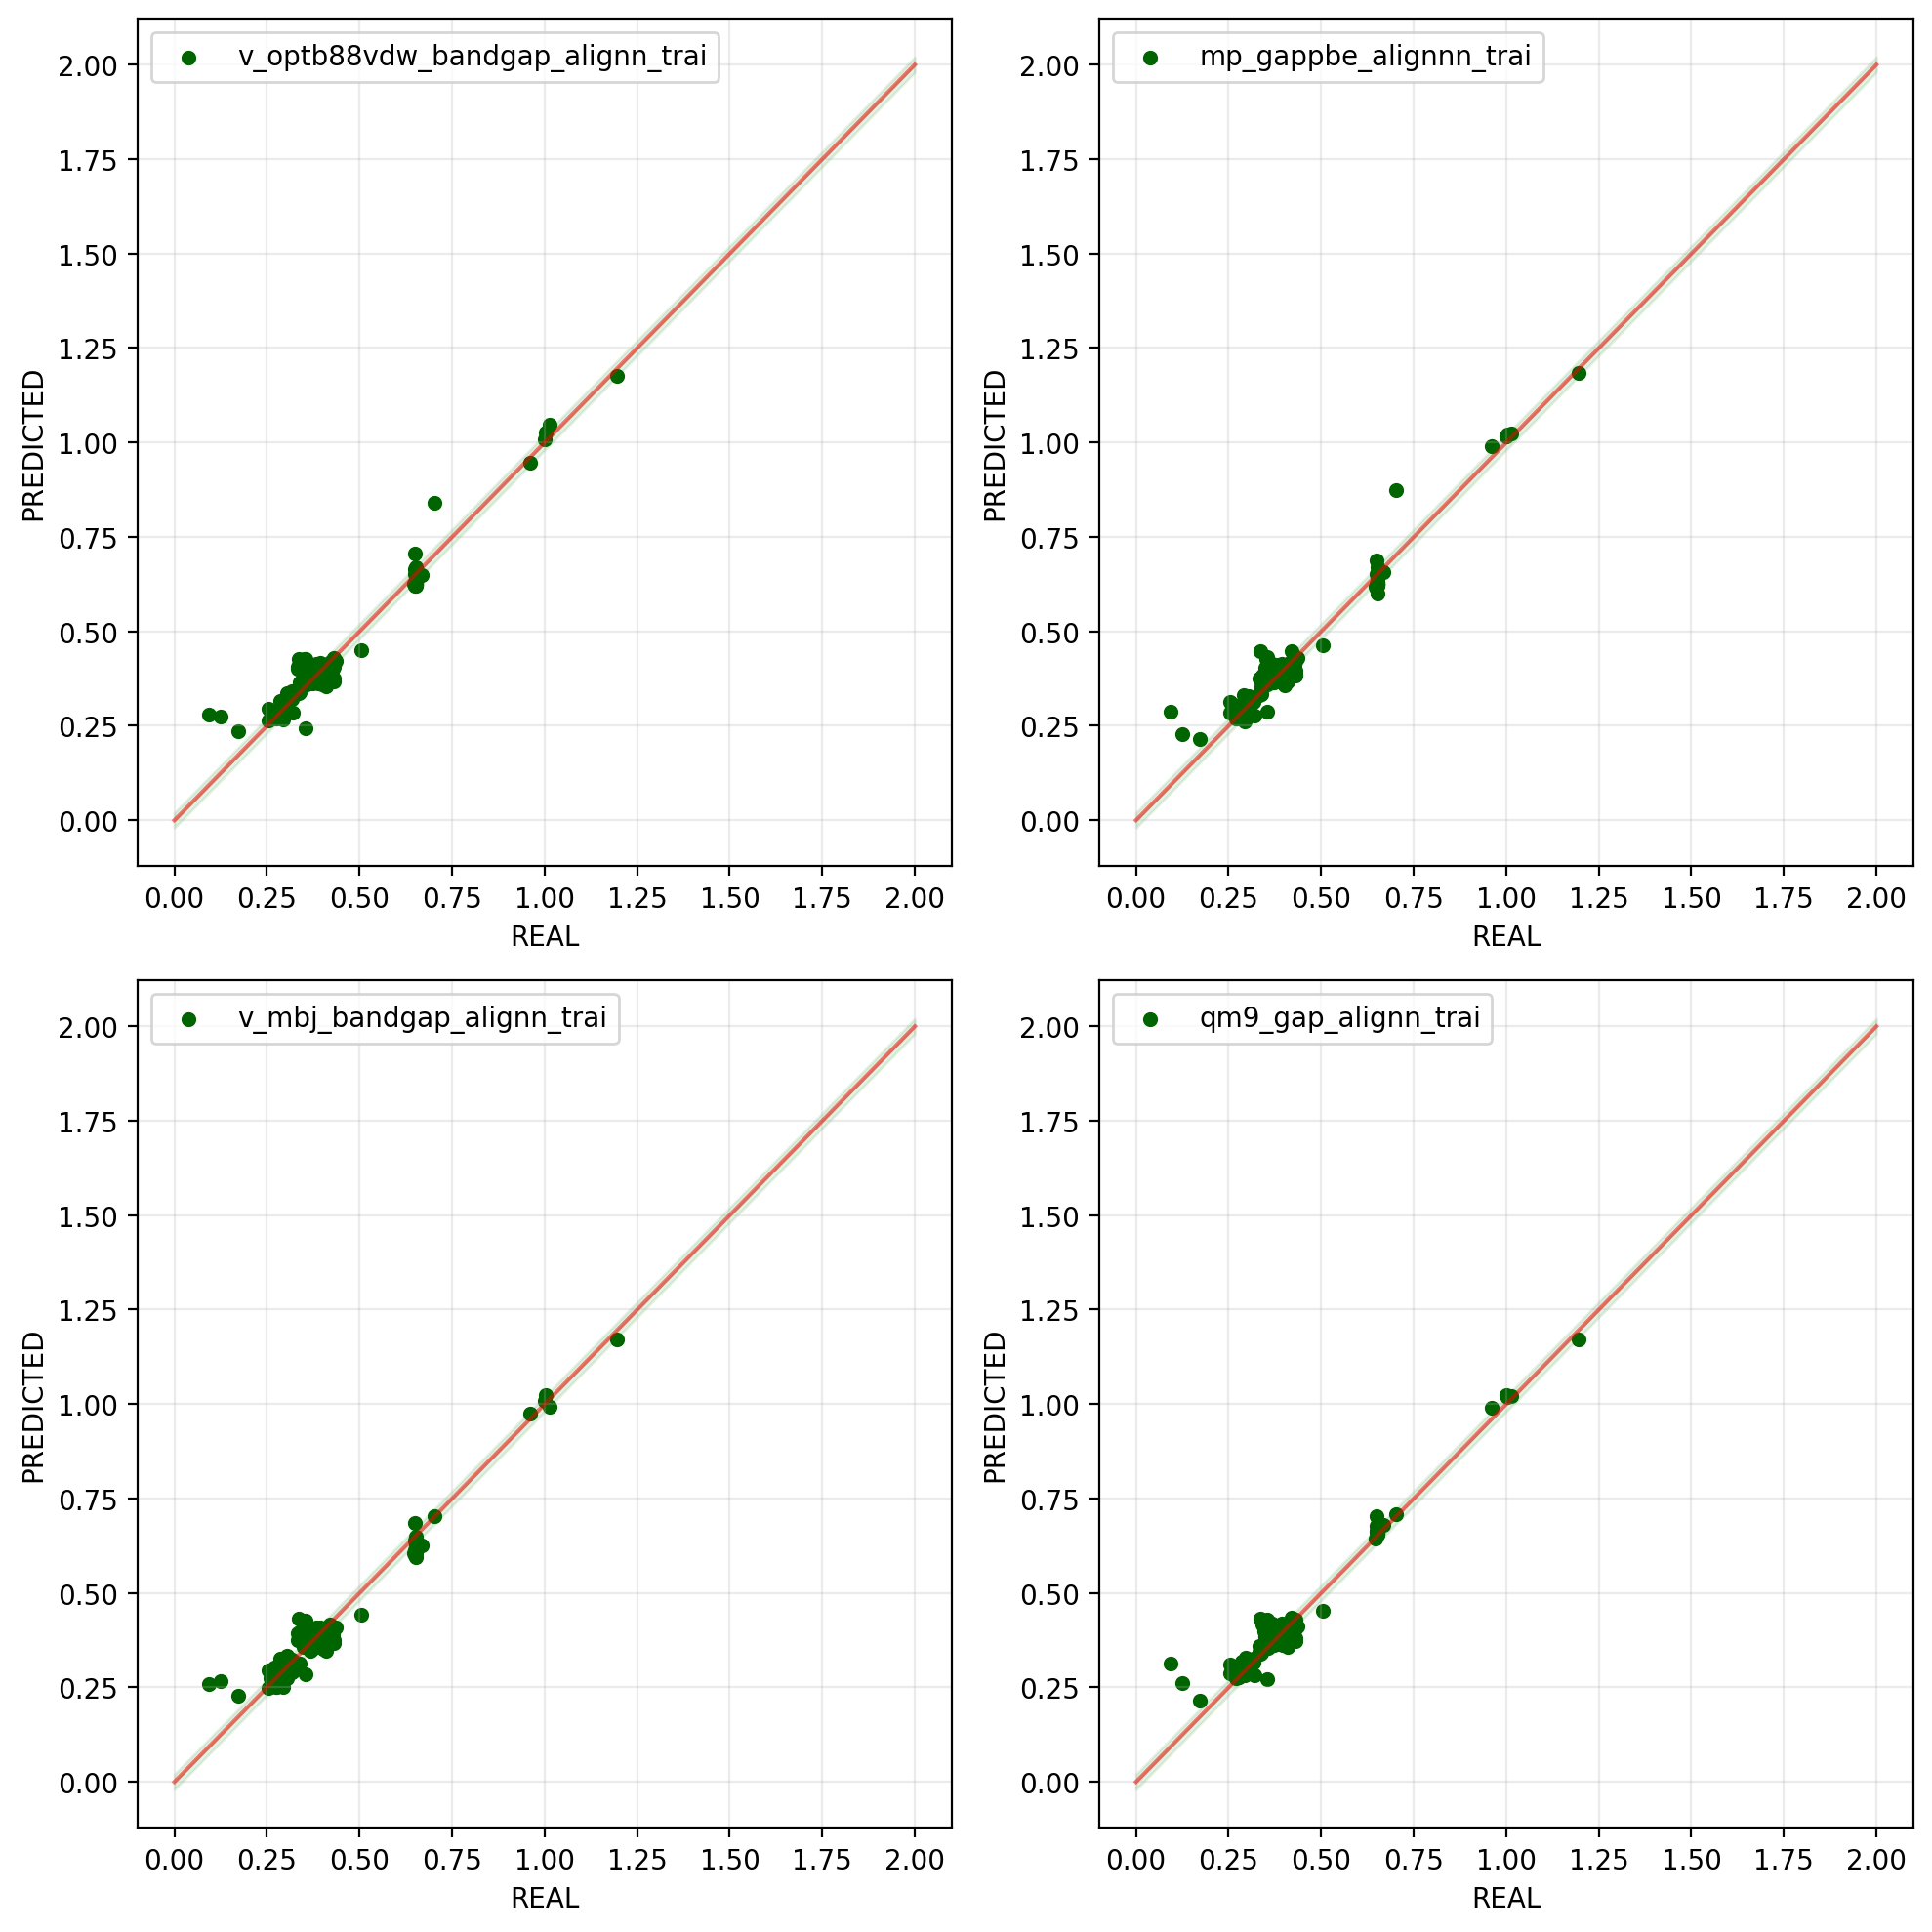

In [158]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
i = 1

for row in ax:
    for col in row:
        temp_.plot(kind='scatter', x='band_gap', y=i, label=num_to_models[i], xlabel='REAL',
                ylabel='PREDICTED', ax=col, grid=0.2, color='DarkGreen')
        col.plot([0,2],[0,2], color='red', alpha=0.5, label='IDEAL');
        i += 1
        col.fill_between([0, 2], [0, 2.0], [0.02, 2.02], alpha=0.1, color='green')
        col.fill_between([0, 2], [0, 2.0], [-0.02, 1.98], alpha=0.1, color='green');
        col.grid(alpha=0.25)
plt.tight_layout()

На какой энергии ошибки слишком большие?

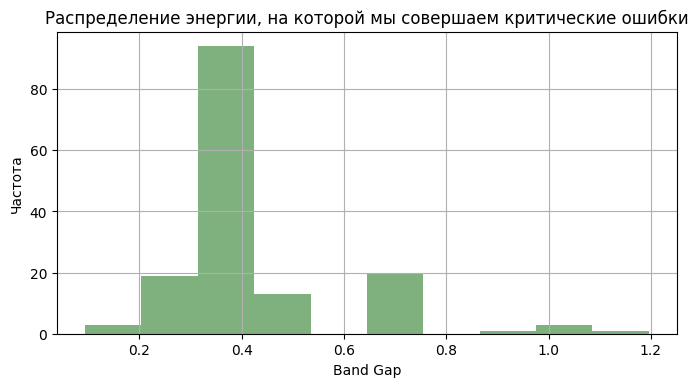

In [140]:
# какая энергия вызывает затруднения?
f, ax = plt.subplots(figsize=(8, 4), dpi=100)
public.loc[problematic_ids.index, :]['band_gap'].hist(ax=ax, color='DarkGreen', alpha=0.5);
ax.set_title('Распределение энергии, на которой мы совершаем критические ошибки')
ax.set_xlabel('Band Gap')
ax.set_ylabel('Частота');

Проблемные материалы в разбиении по формулам:

In [30]:
all_counts = public.value_counts('formula')
problematic_counts = public.loc[problematic_ids.index, :].value_counts('formula')

pd.concat([all_counts.rename('overall'), problematic_counts.rename('errors')], axis=1).fillna(0).astype(int)

,overall,errors
formula,,
Mo63 W1 Se1 S126,716,1
Mo63 Se1 S126,702,58
Mo63 W1 S126,380,23
Mo63 Se2 S126,377,29
Mo63 S126,363,40
Mo63 W1 Se2 S126,360,0
Mo64 Se1 S126,18,0
Mo64 S126,12,1
Mo63 S127,8,1


### Ошибки в рамках каждой из формул

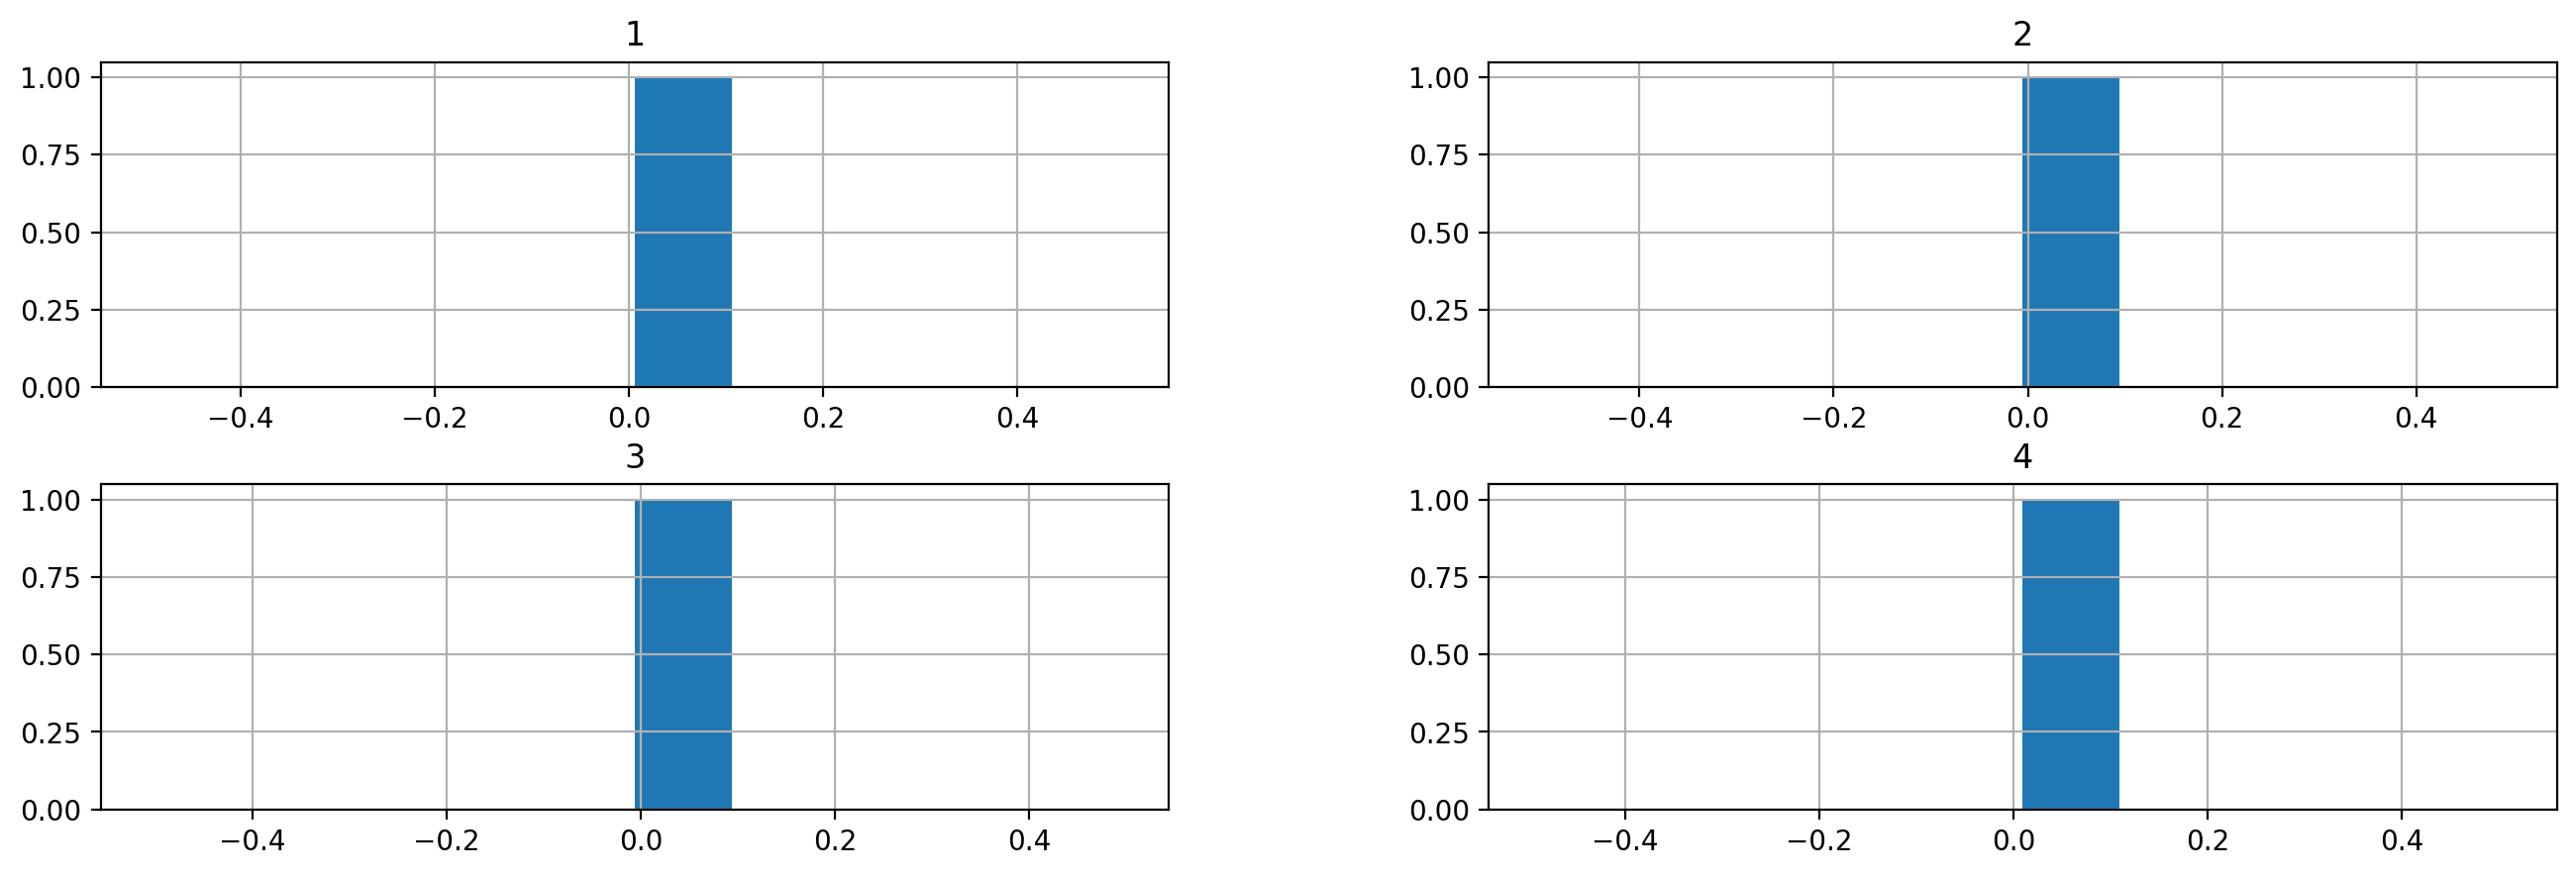

In [71]:
# Mo63 W1 S128	1	0
public[public['formula'] == 'Mo63 W1 S128'].iloc[:, -4:].hist();

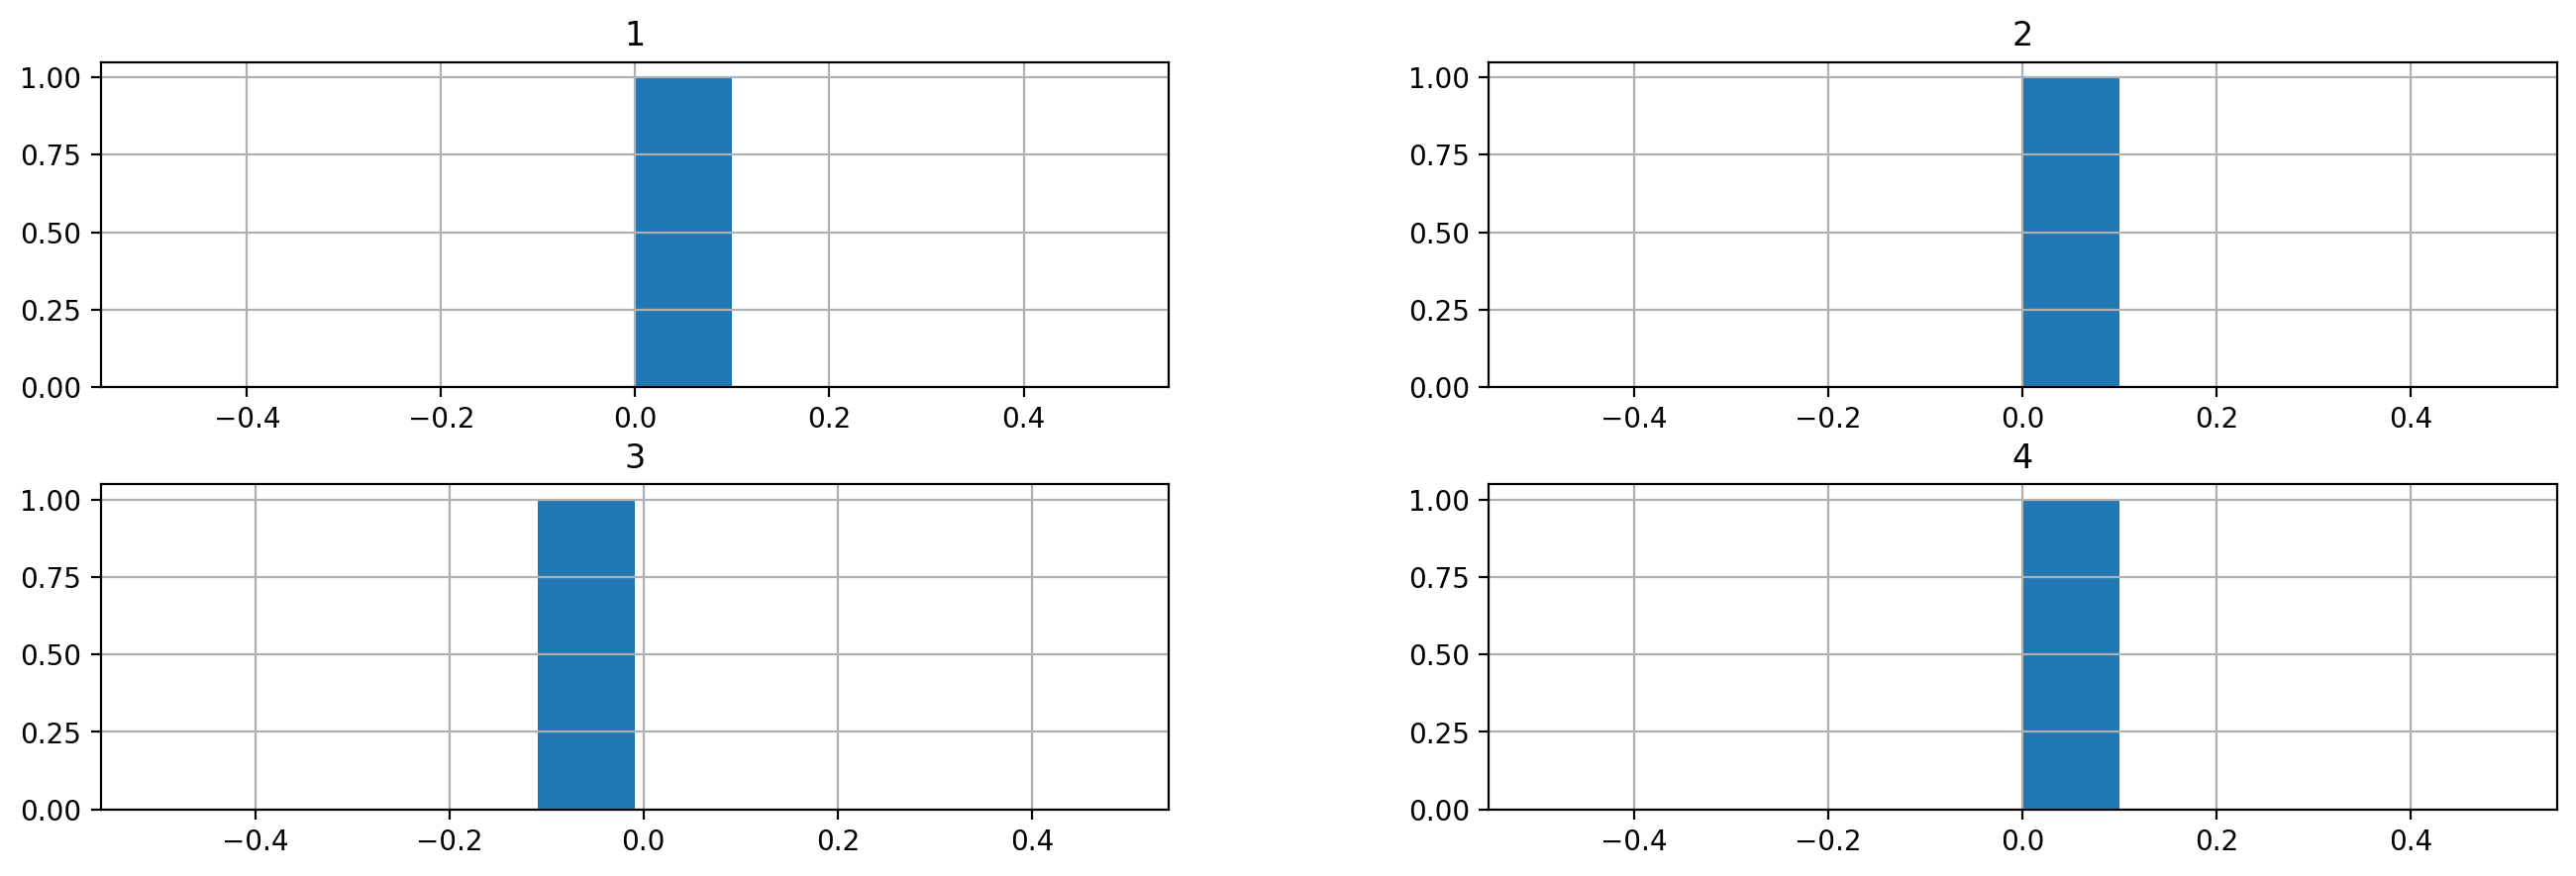

In [72]:
# Mo63 S128	1	0
public[public['formula'] == 'Mo63 S128'].iloc[:, -4:].hist();

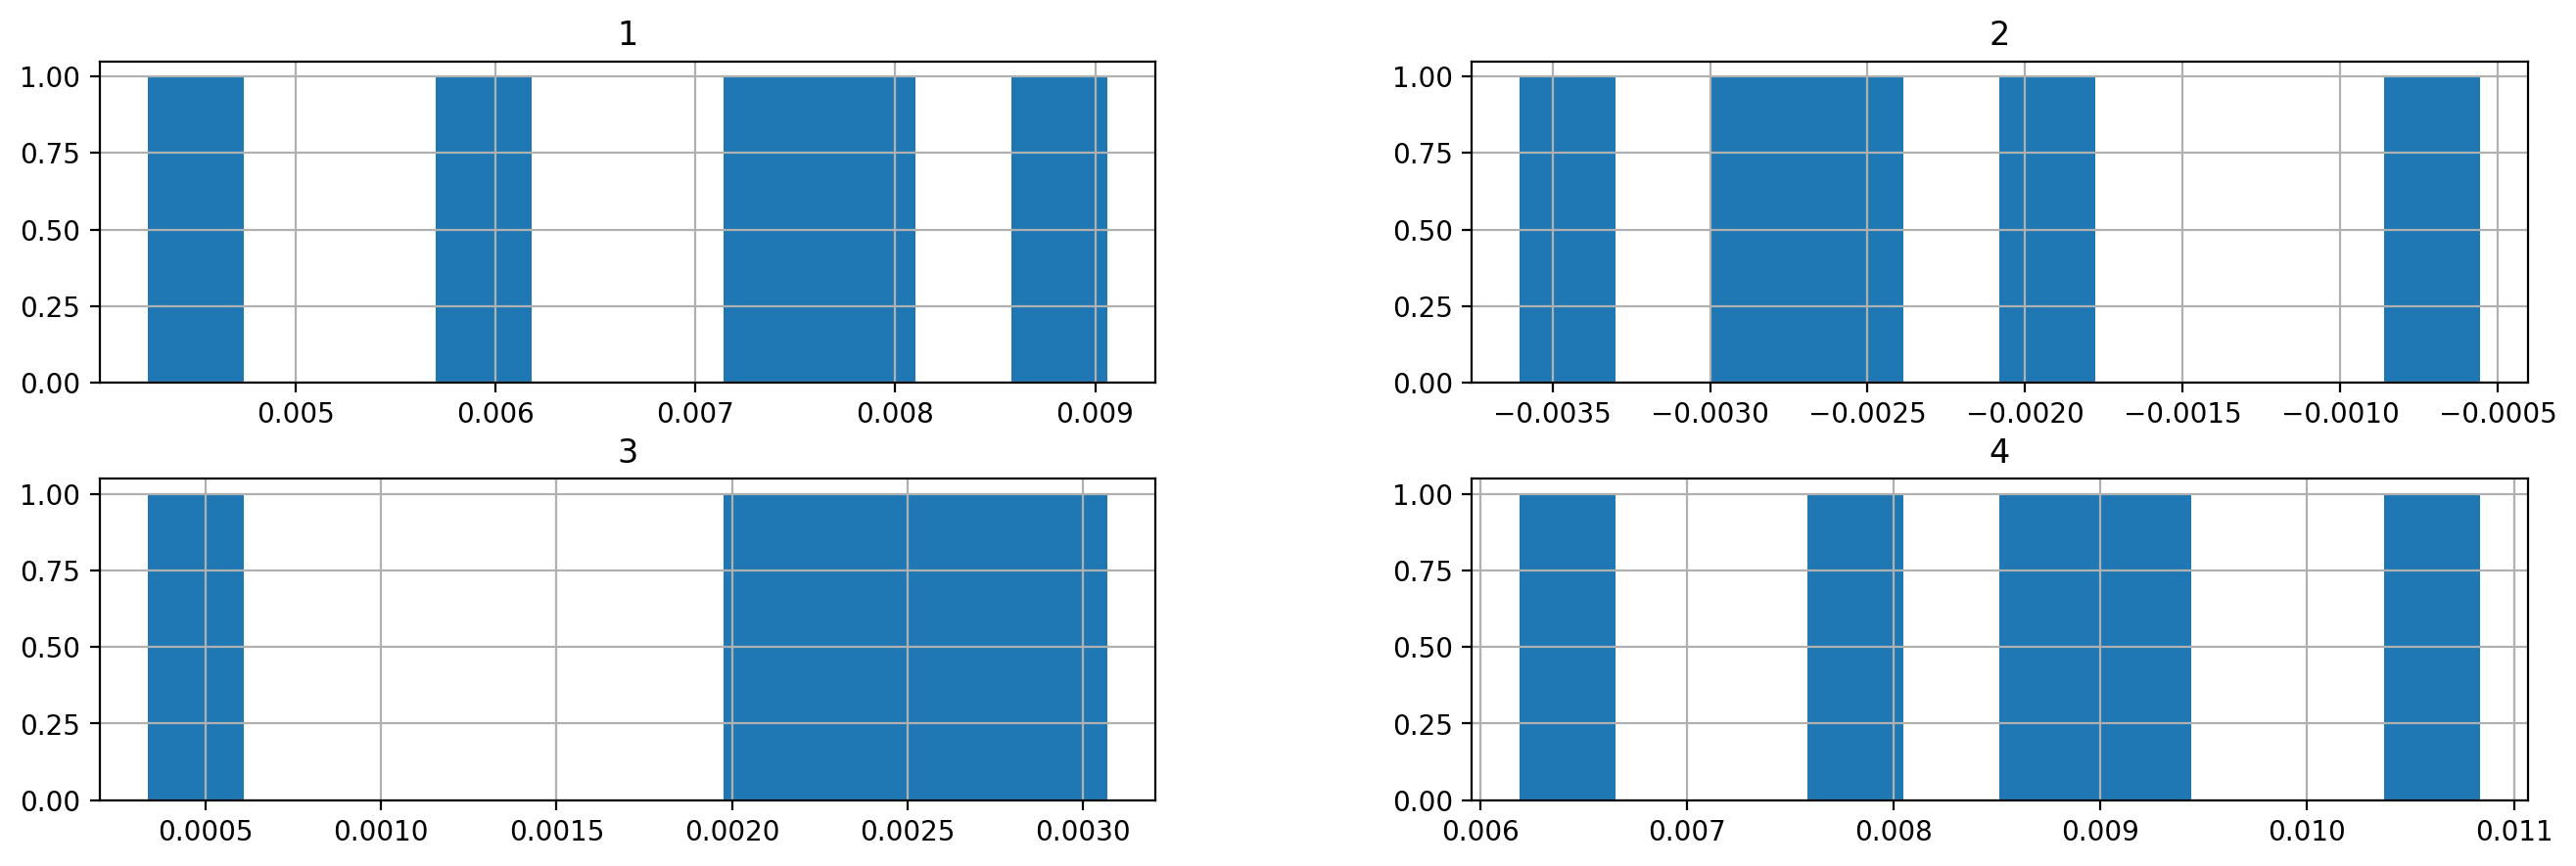

In [73]:
# Mo63 W1 Se1 S127	5	0
public[public['formula'] == 'Mo63 W1 Se1 S127'].iloc[:, -4:].hist();

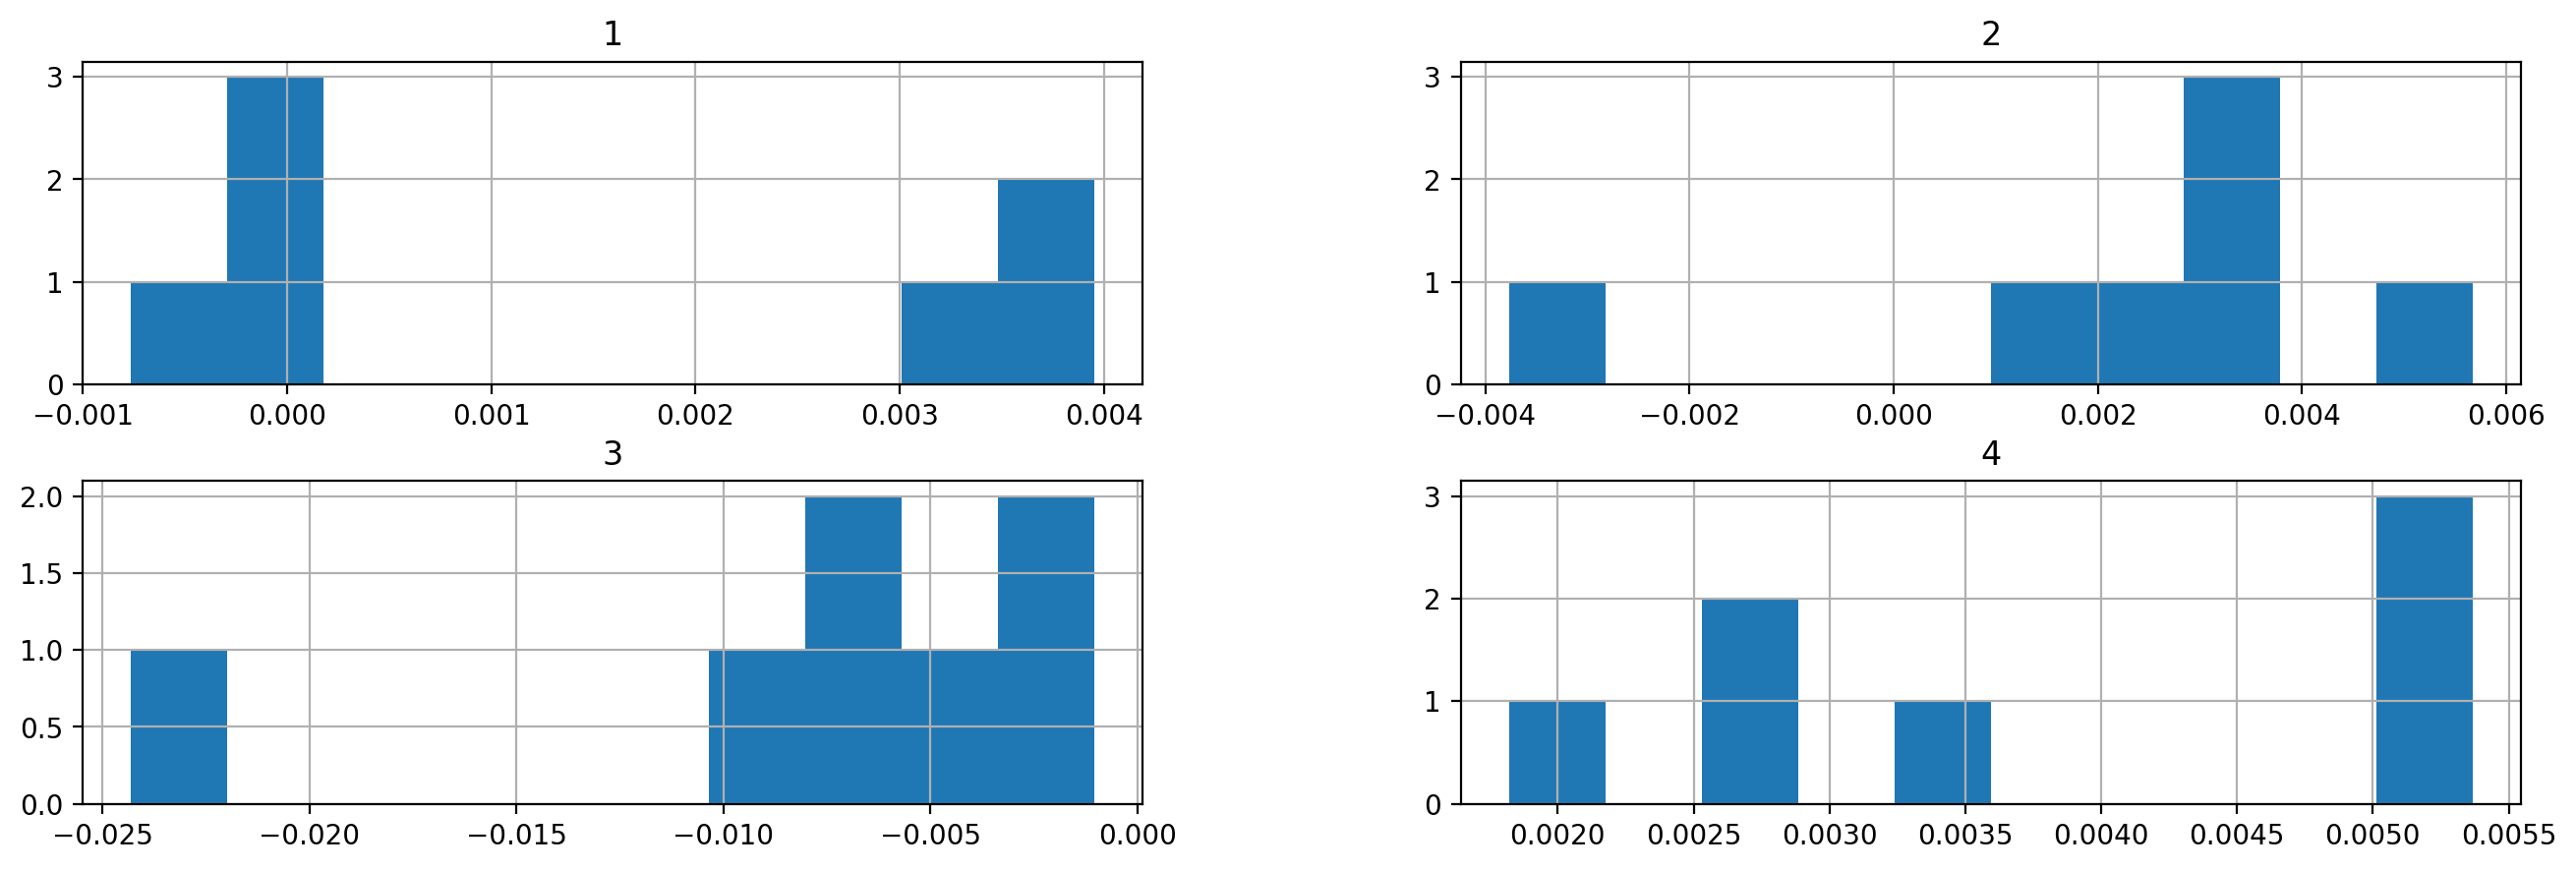

In [74]:
# Mo63 Se1 S127	7	1
public[public['formula'] == 'Mo63 Se1 S127'].iloc[:, -4:].hist();

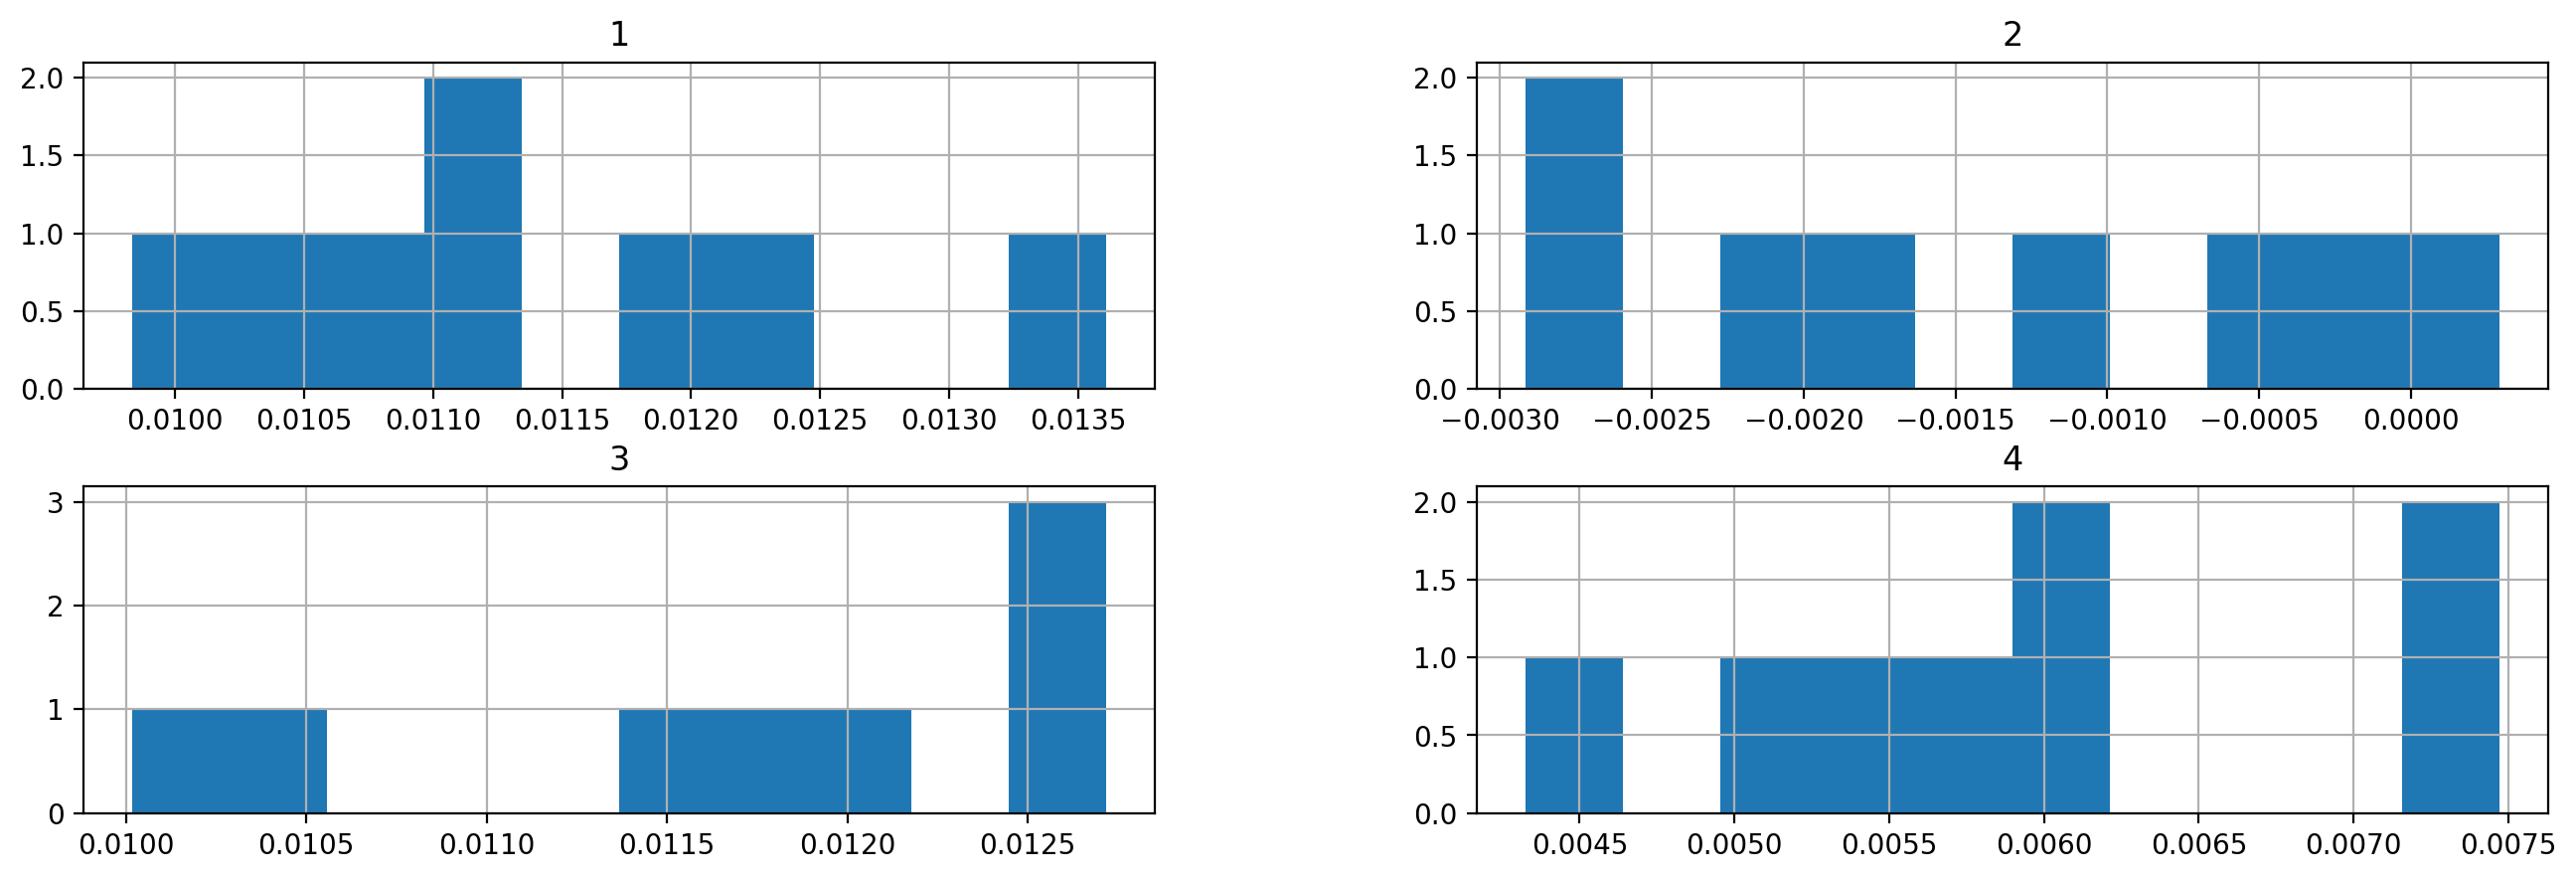

In [75]:
# Mo64 Se2 S126	8	0
public[public['formula'] == 'Mo64 Se2 S126'].iloc[:, -4:].hist();

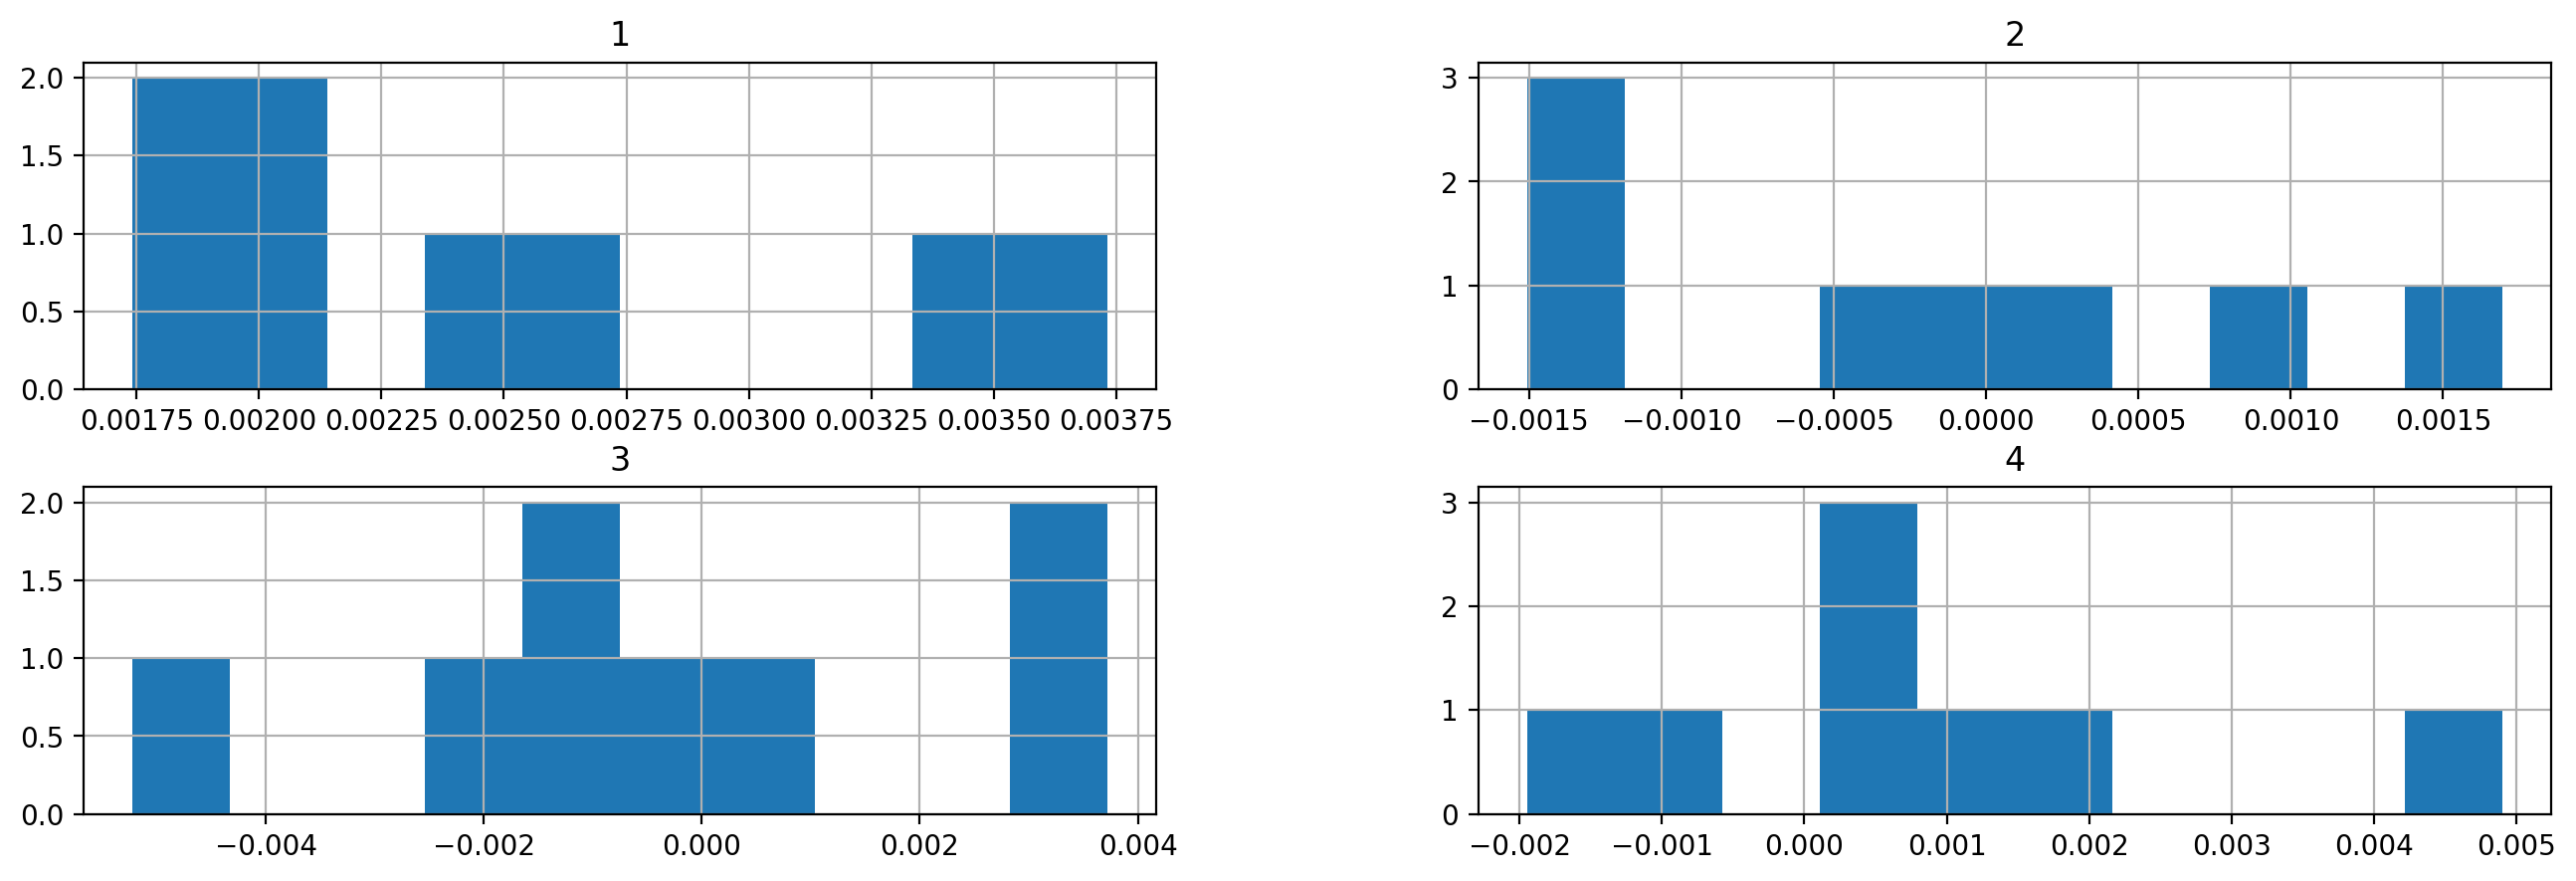

In [70]:
# Mo63 W1 S127	8	0
public[public['formula'] == 'Mo63 W1 S127'].iloc[:, -4:].hist();

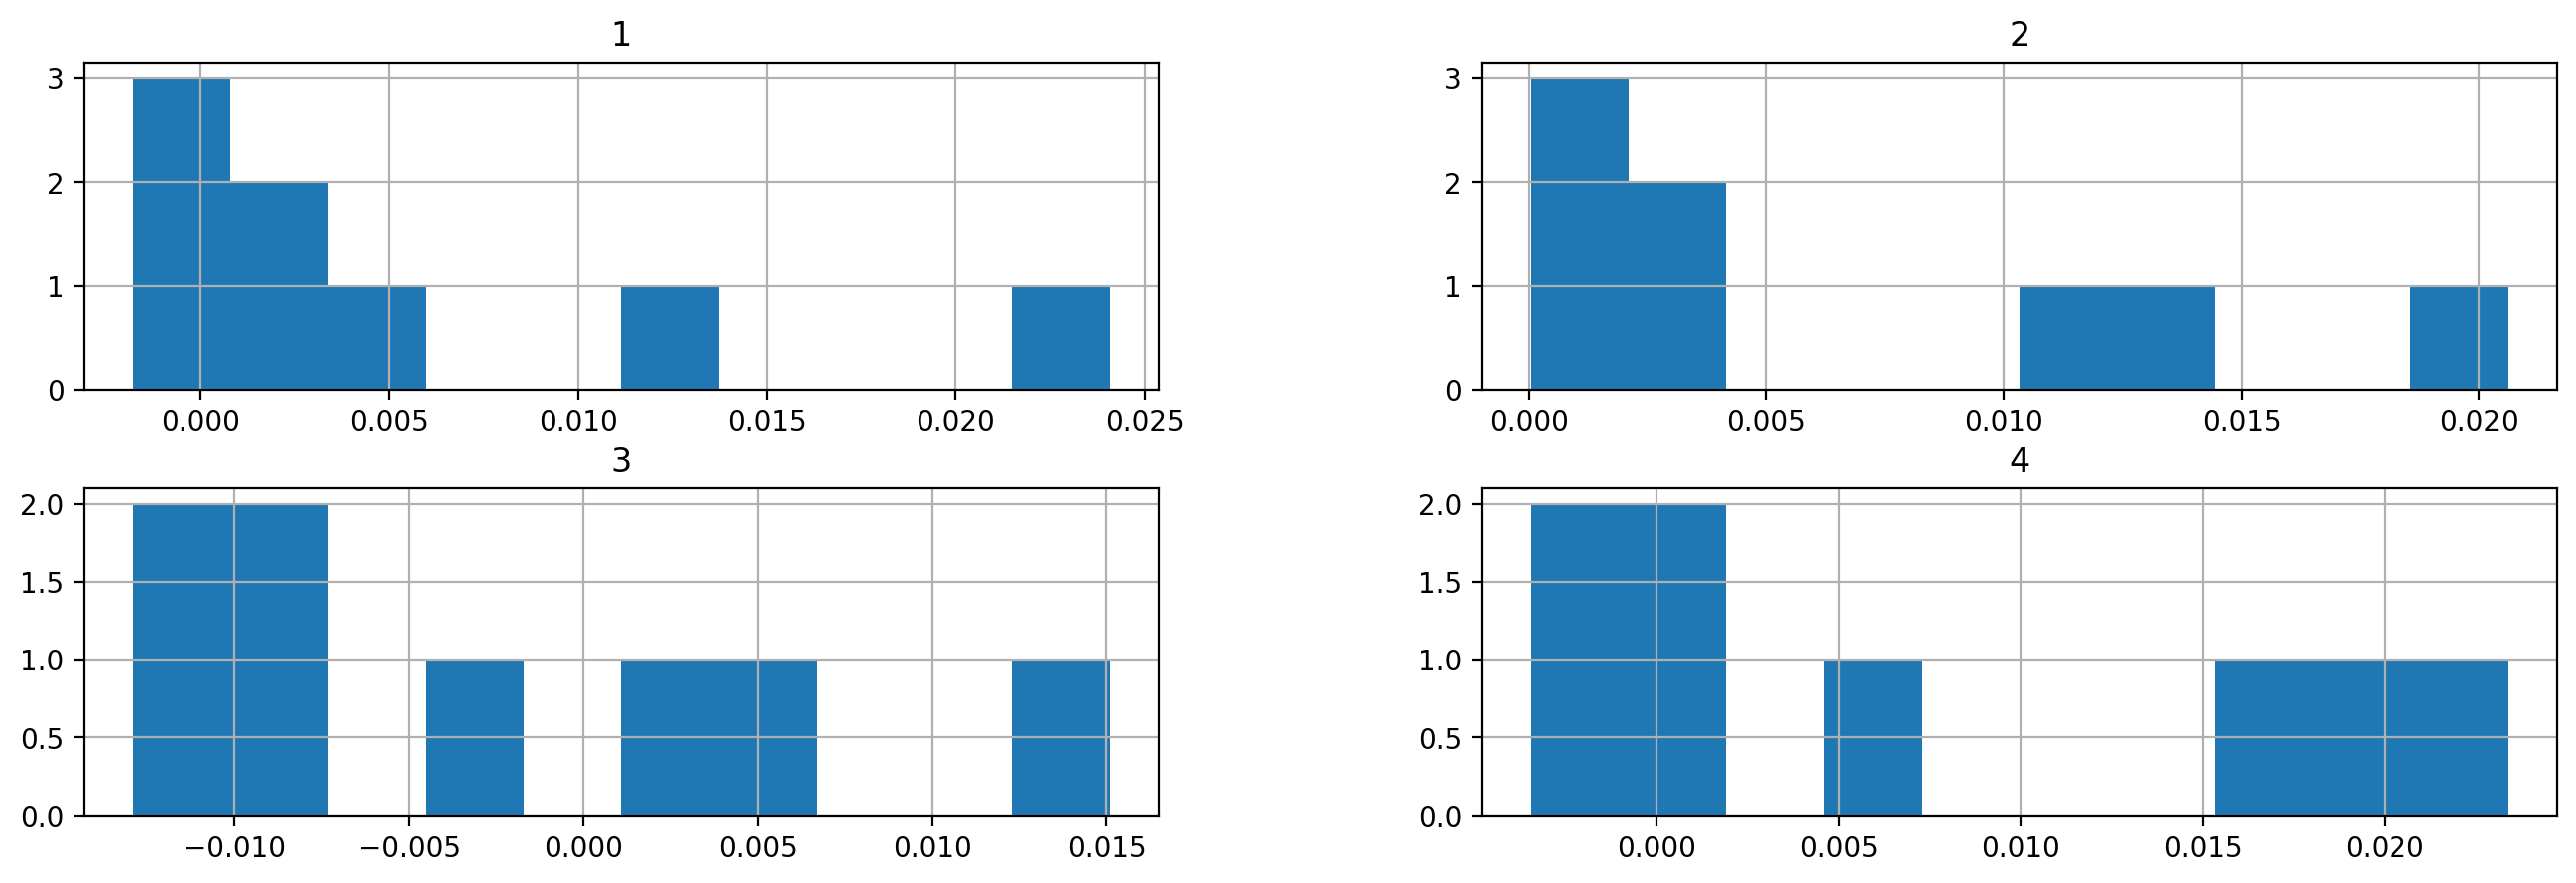

In [69]:
# Mo63 S127	8	1
public[public['formula'] == 'Mo63 S127'].iloc[:, -4:].hist();

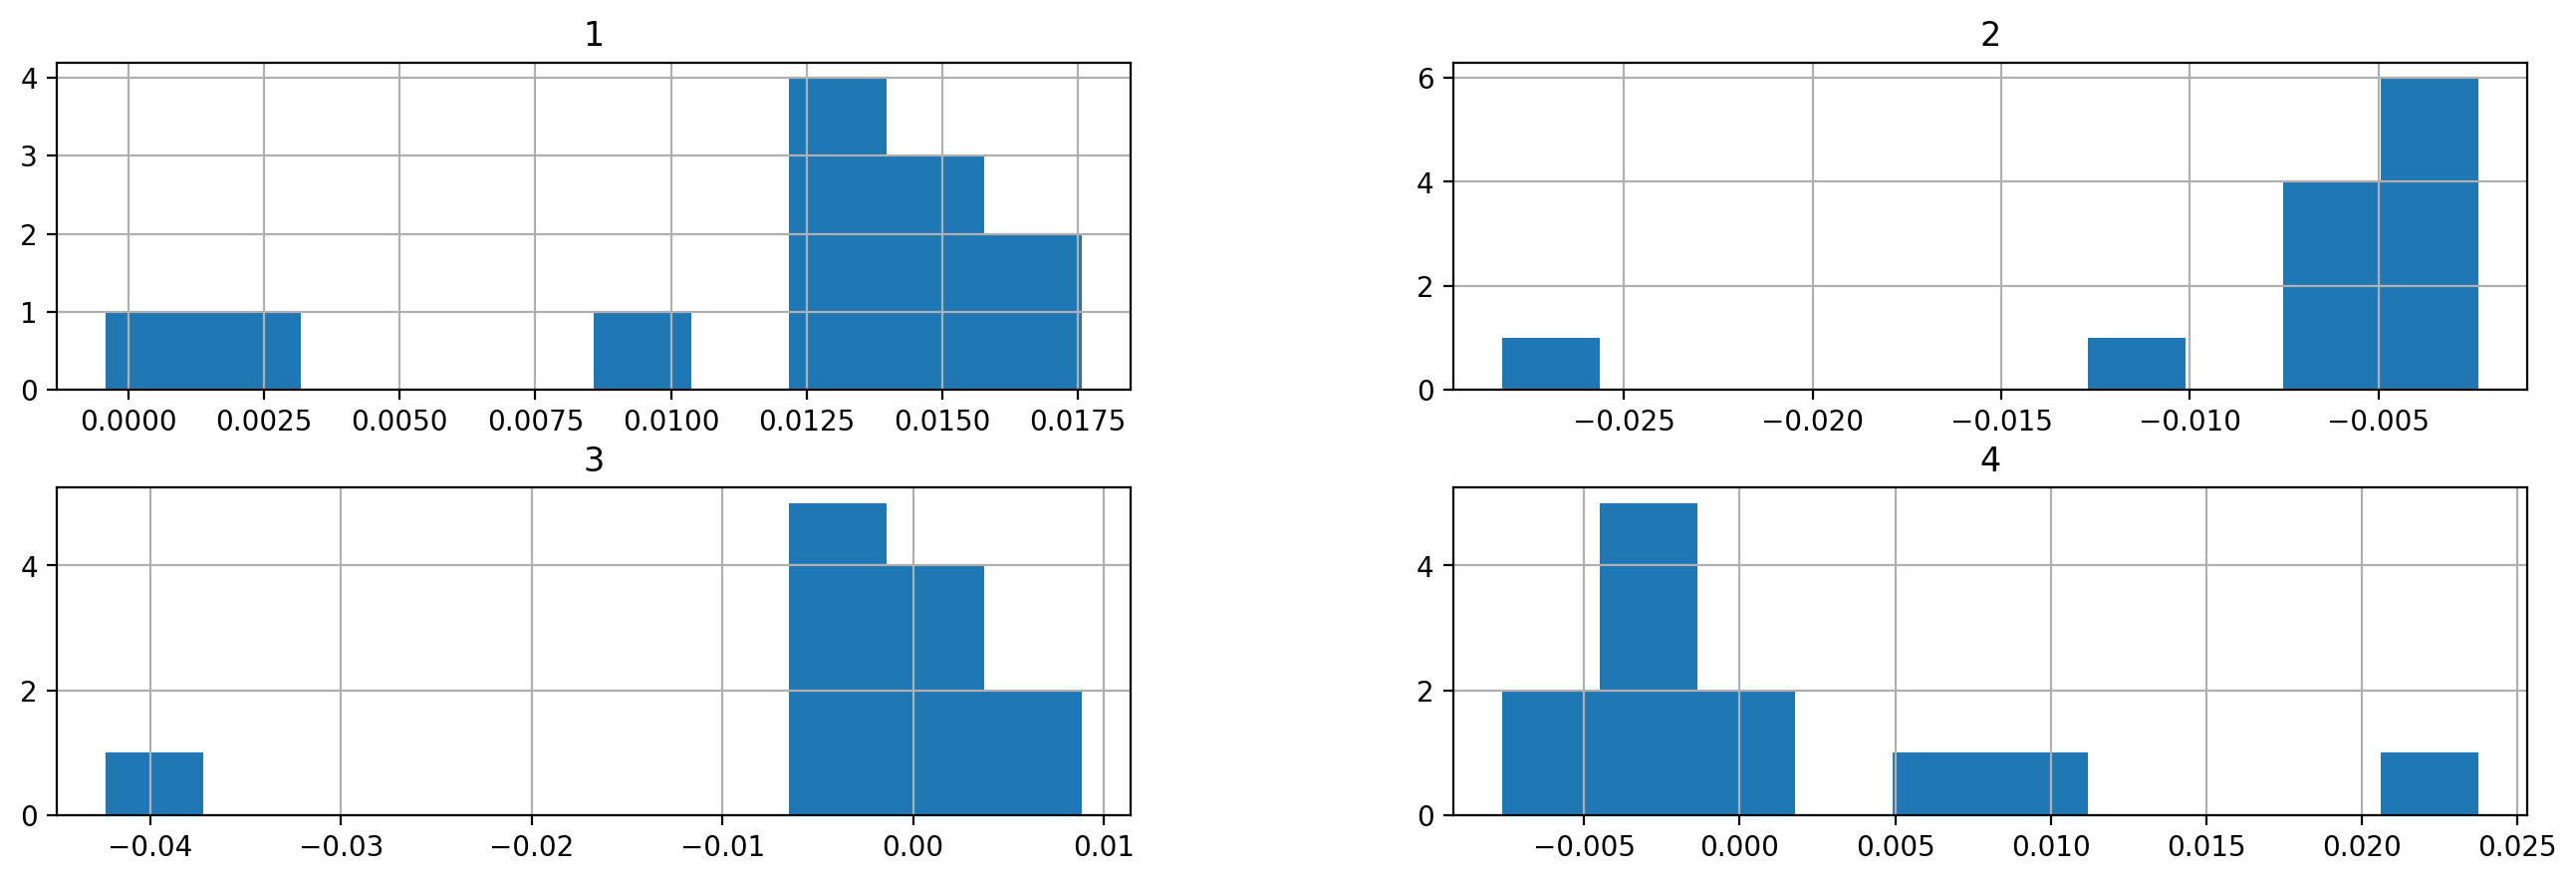

In [61]:
# Mo64 S126	12	1
public[public['formula'] == 'Mo64 S126'].iloc[:, -4:].hist();

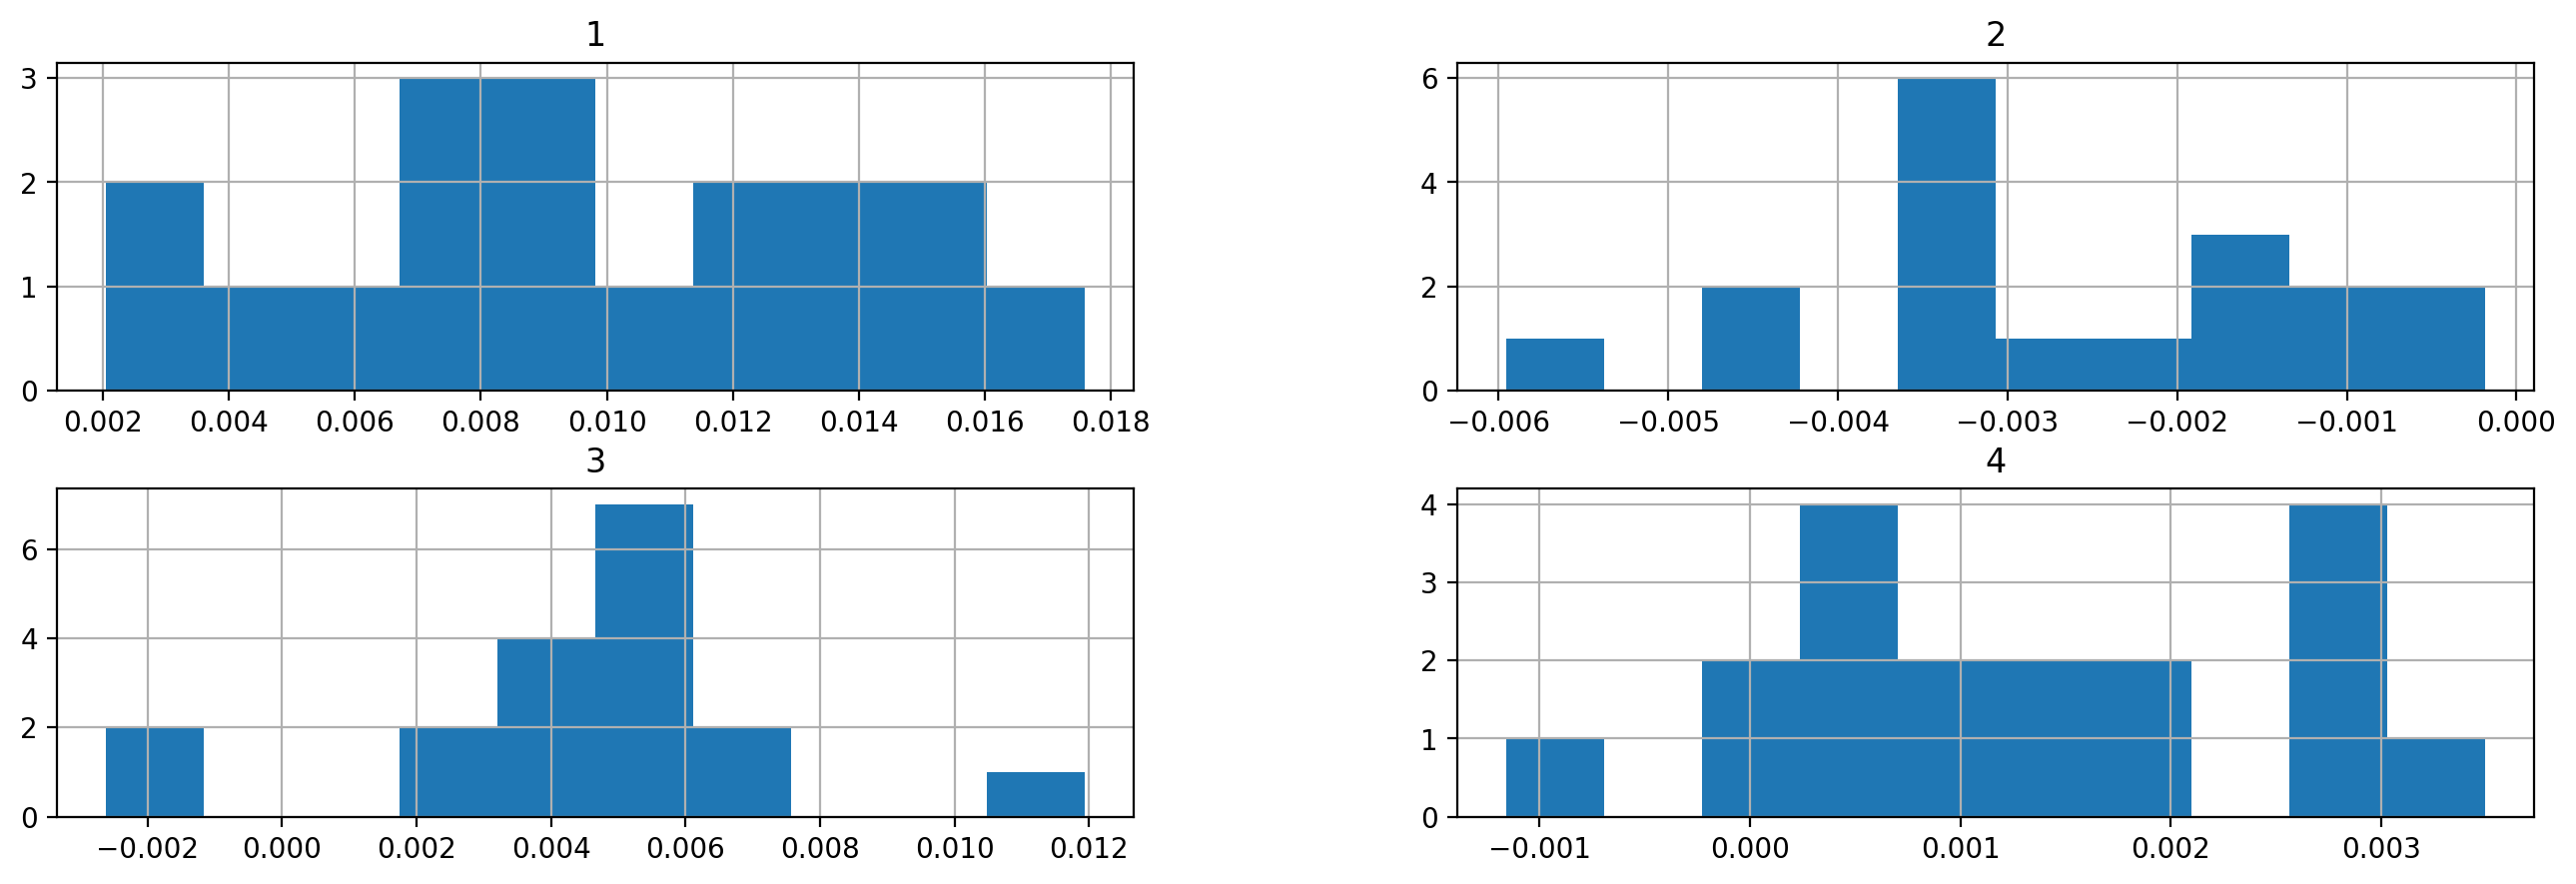

In [62]:
# Mo64 Se1 S126	18	0
public[public['formula'] == 'Mo64 Se1 S126'].iloc[:, -4:].hist();

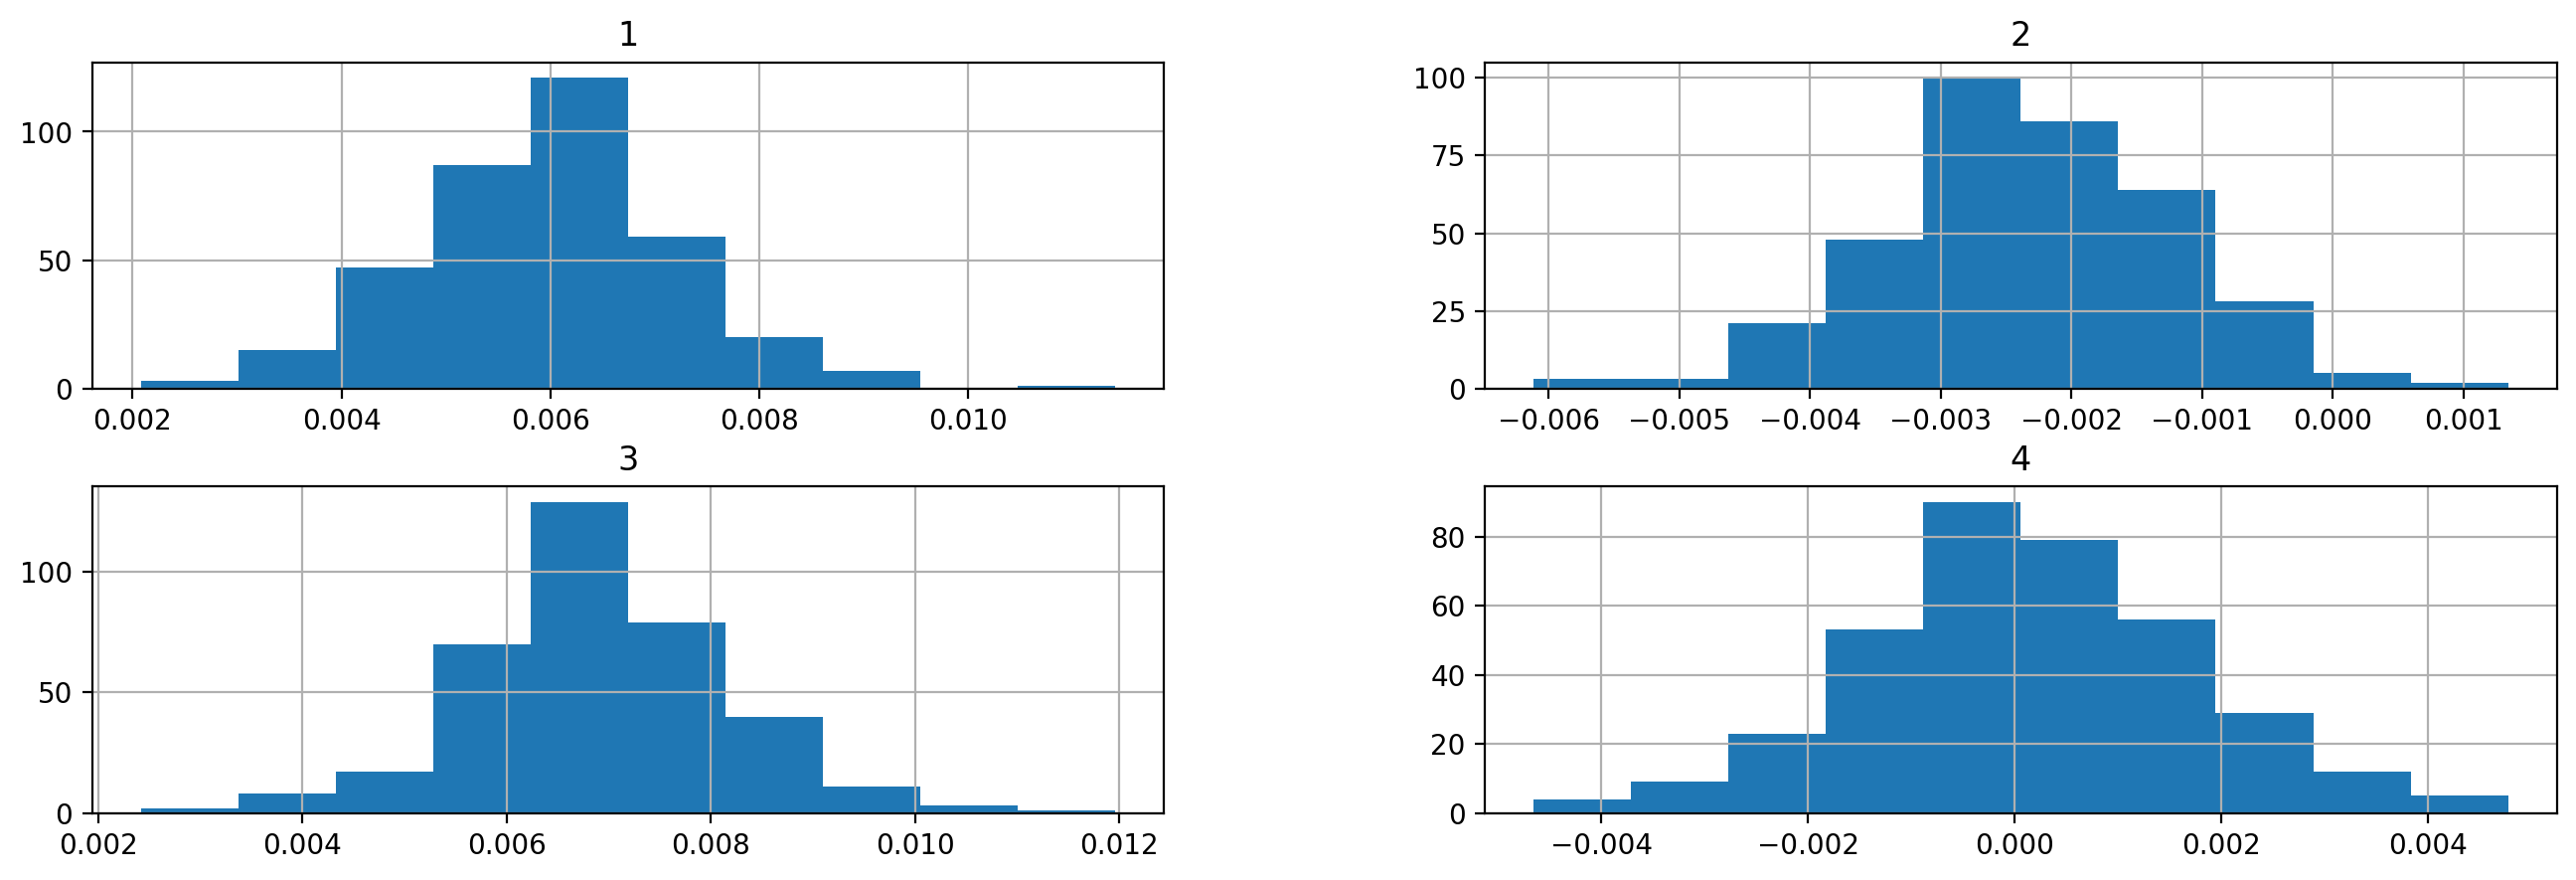

In [63]:
# Mo63 W1 Se2 S126	360	0
public[public['formula'] == 'Mo63 W1 Se2 S126'].iloc[:, -4:].hist();

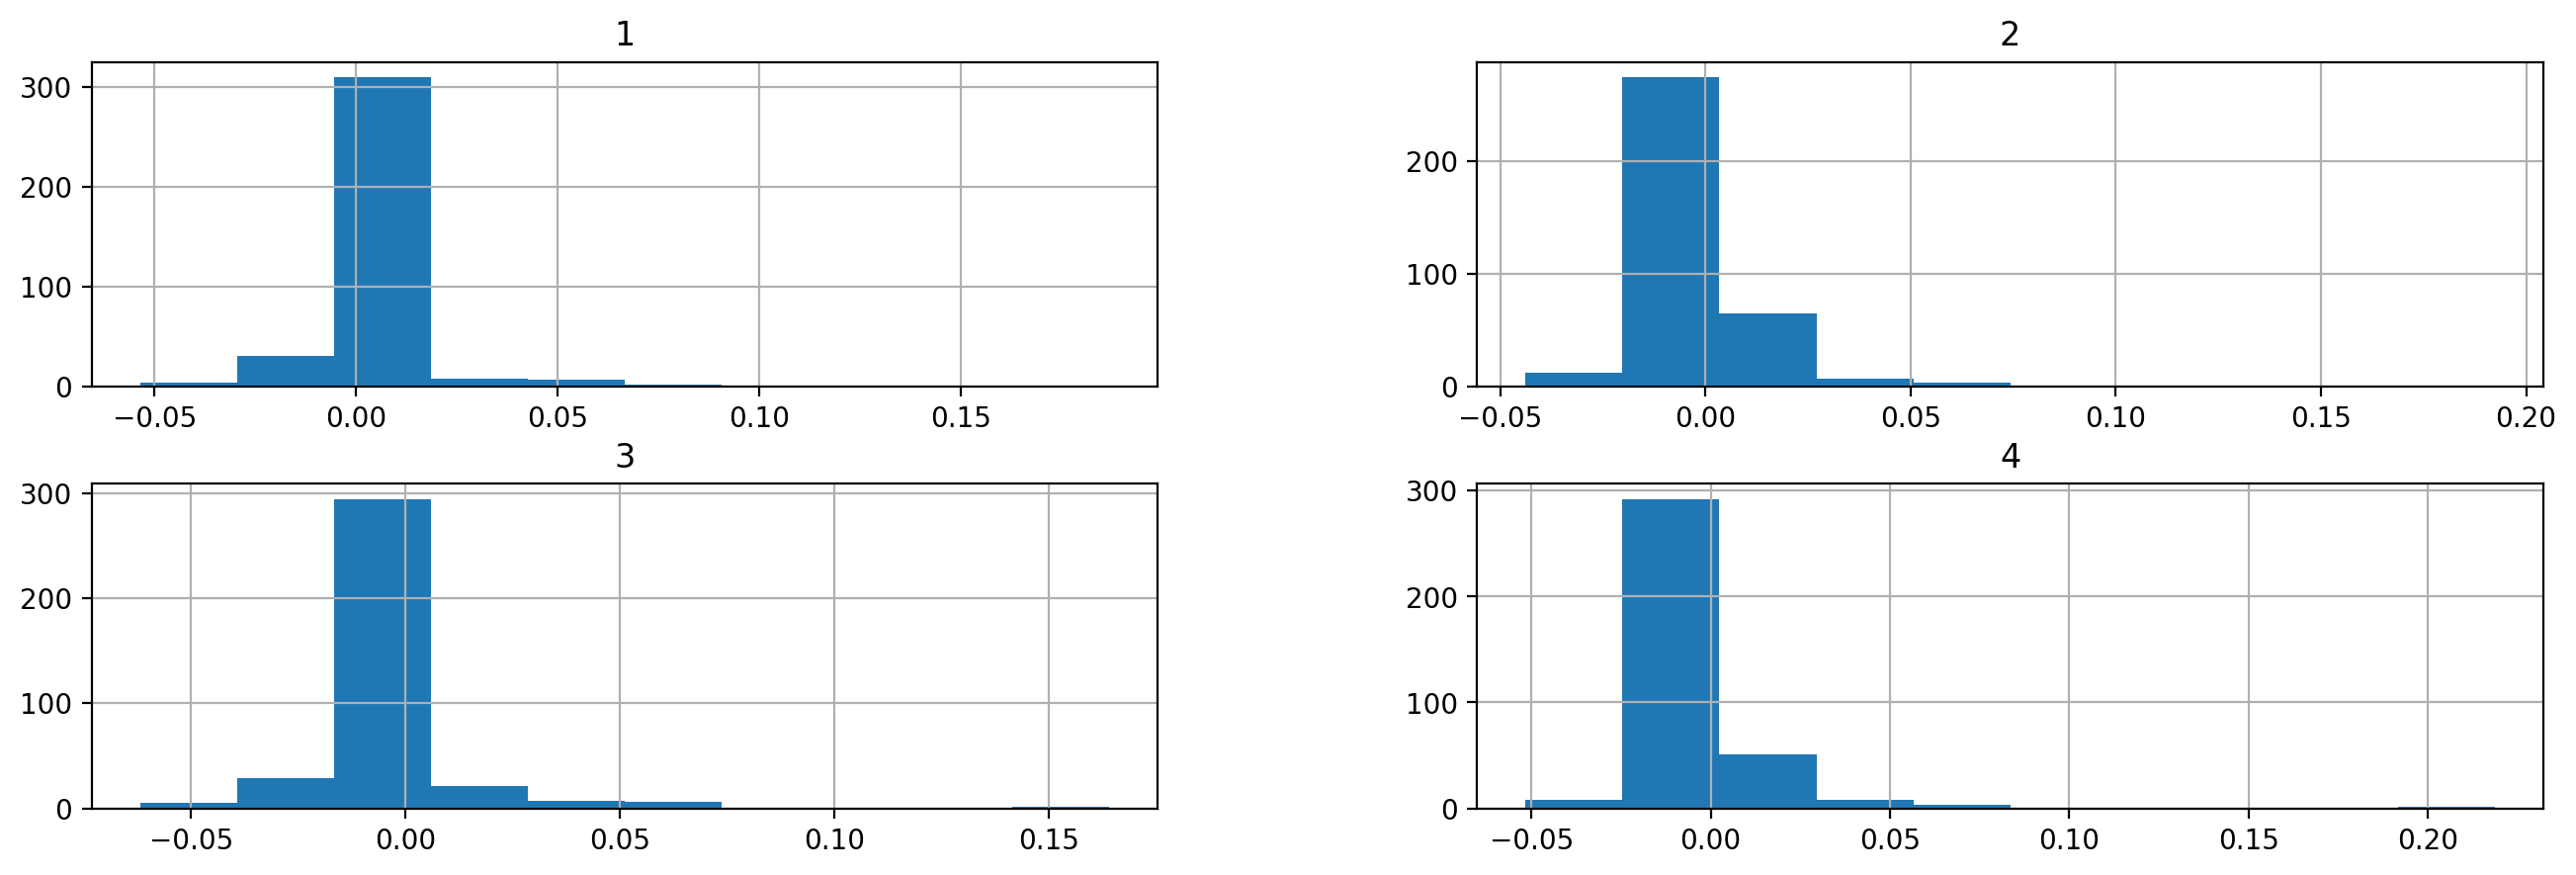

In [64]:
# Mo63 S126	363	40
public[public['formula'] == 'Mo63 S126'].iloc[:, -4:].hist();

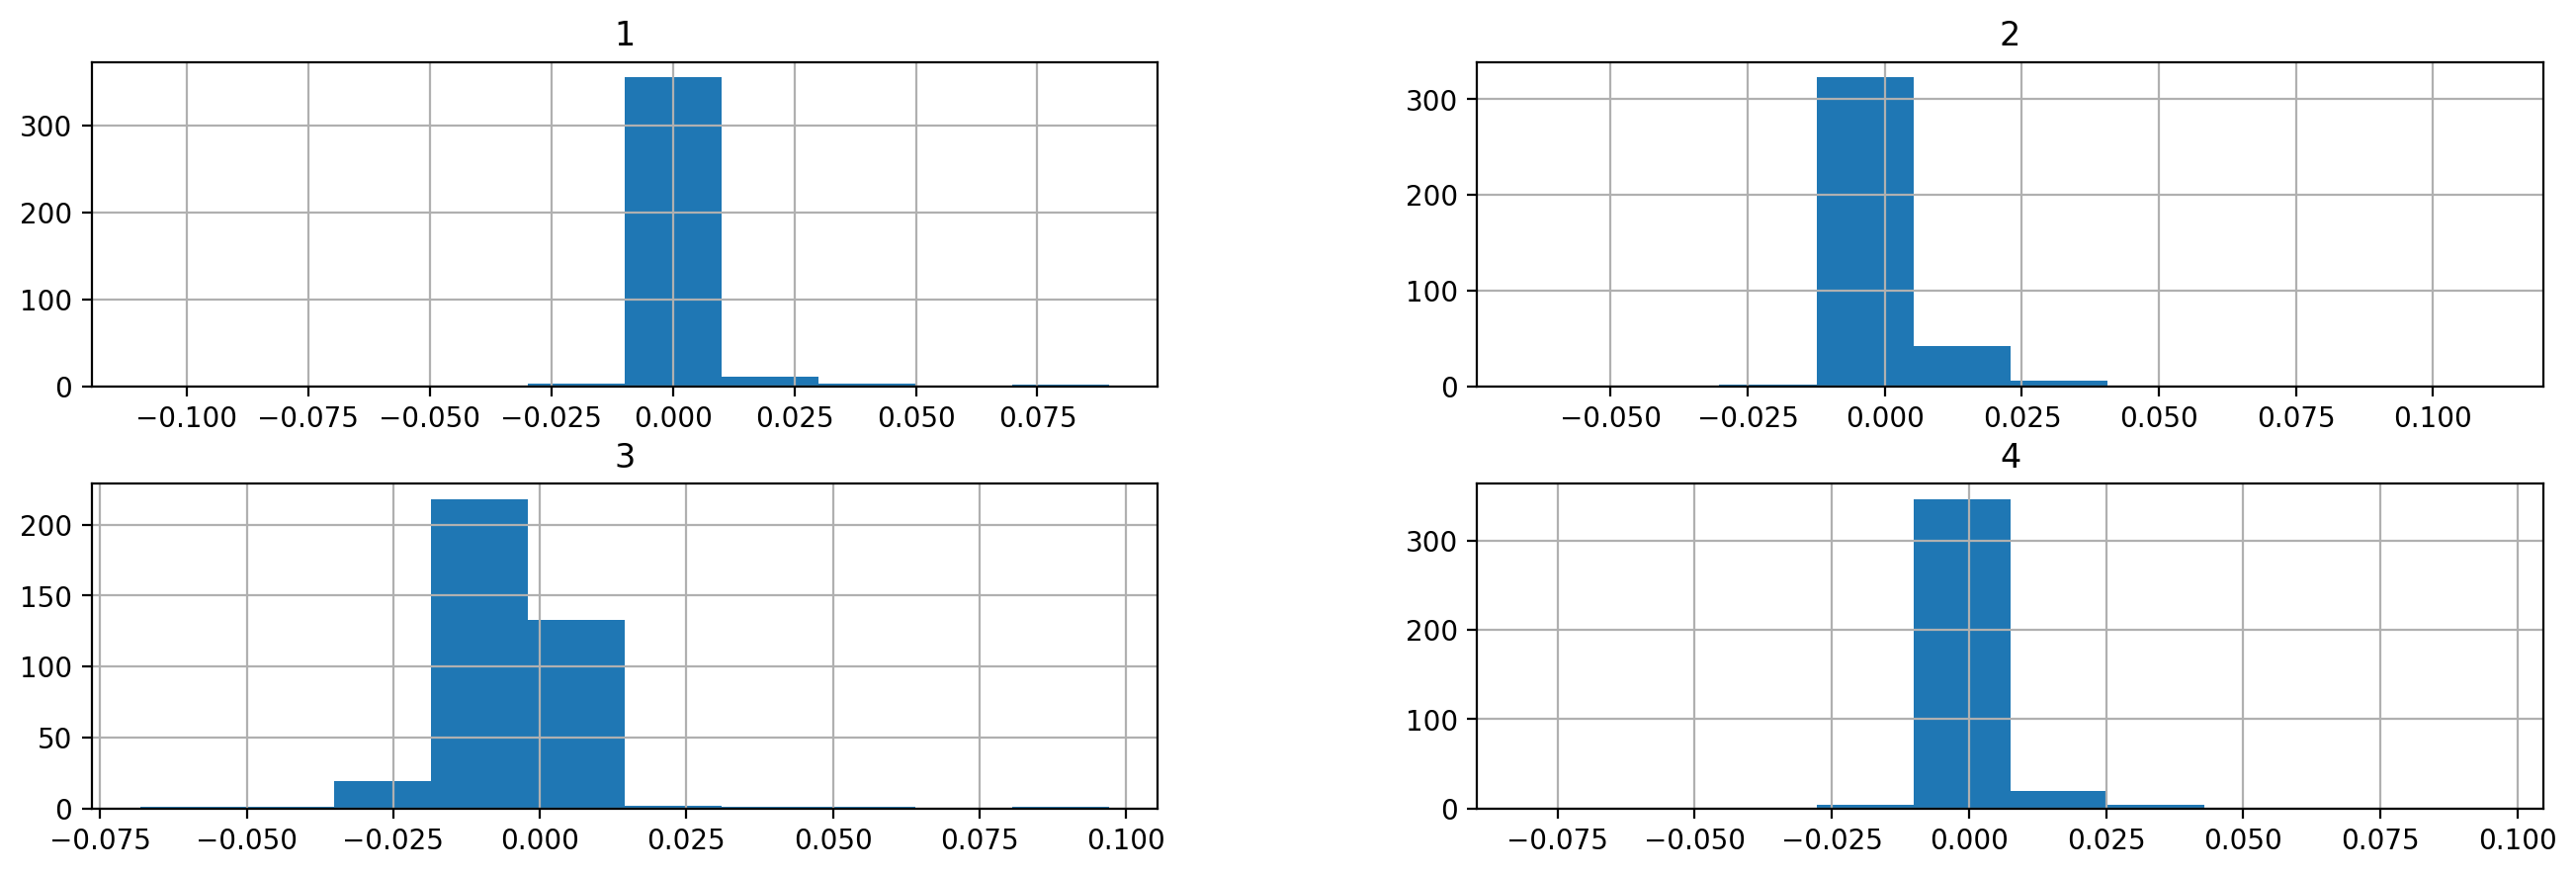

In [65]:
# Mo63 Se2 S126	377	29
public[public['formula'] == 'Mo63 Se2 S126'].iloc[:, -4:].hist();

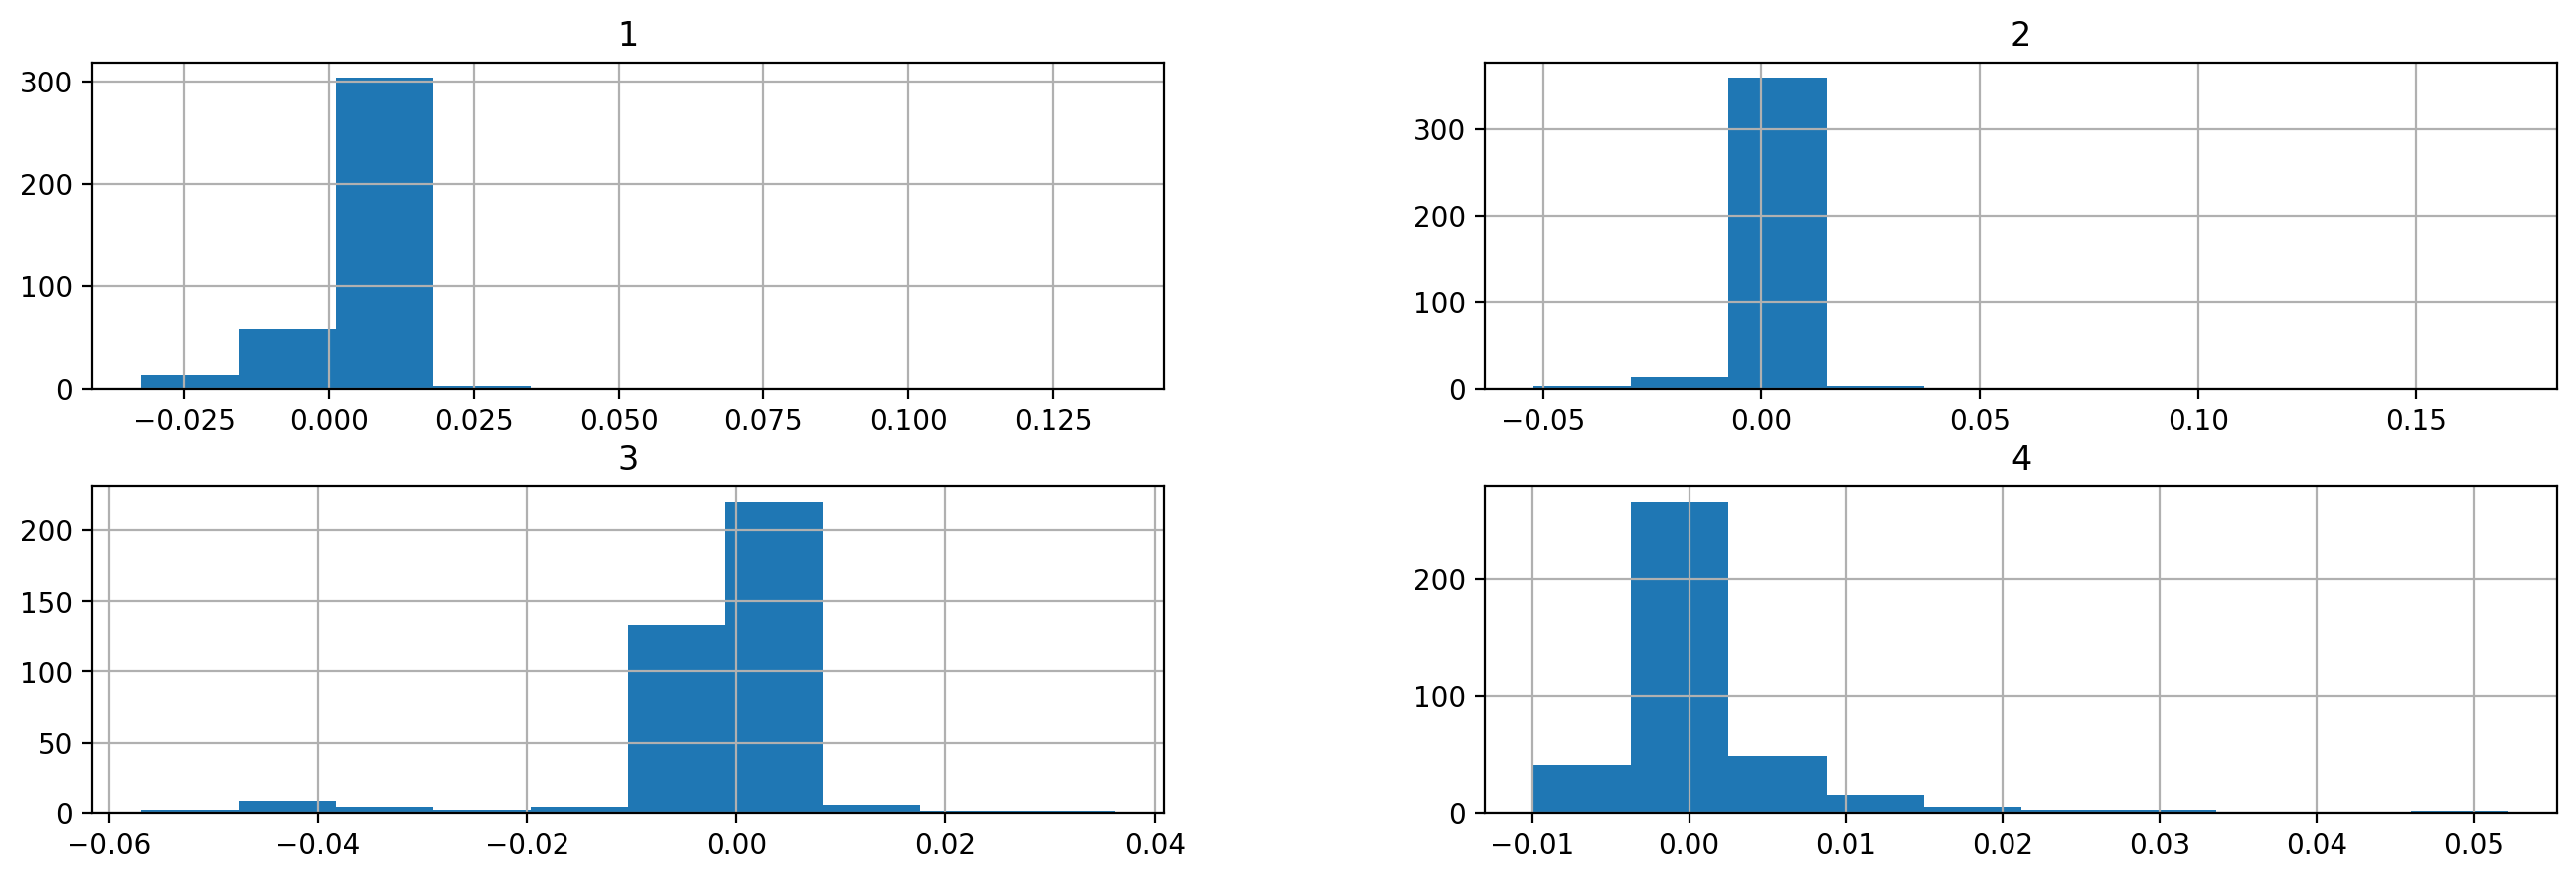

In [66]:
# Mo63 W1 S126	380	23
public[public['formula'] == 'Mo63 W1 S126'].iloc[:, -4:].hist();

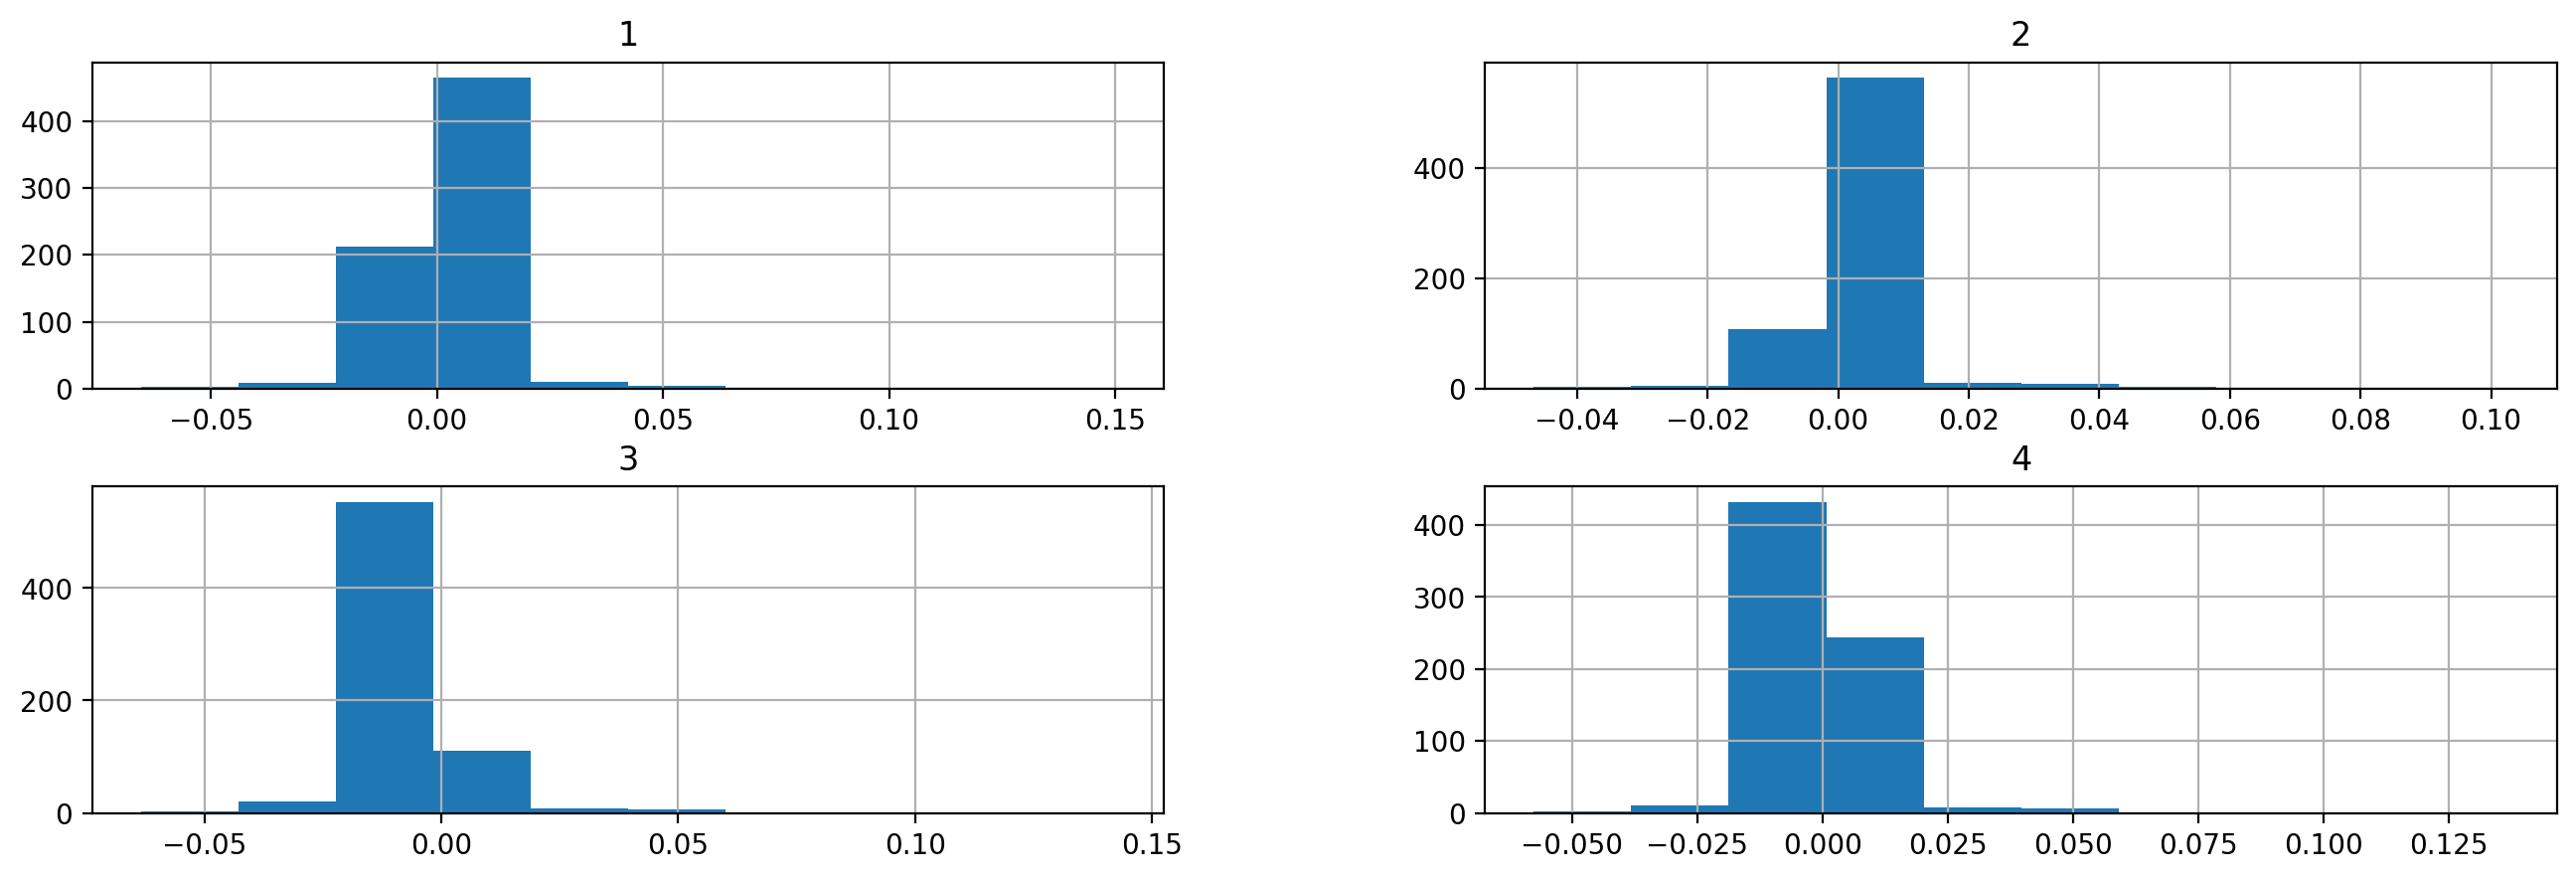

In [67]:
# Mo63 Se1 S126	702	58
public[public['formula'] == 'Mo63 Se1 S126'].iloc[:, -4:].hist();

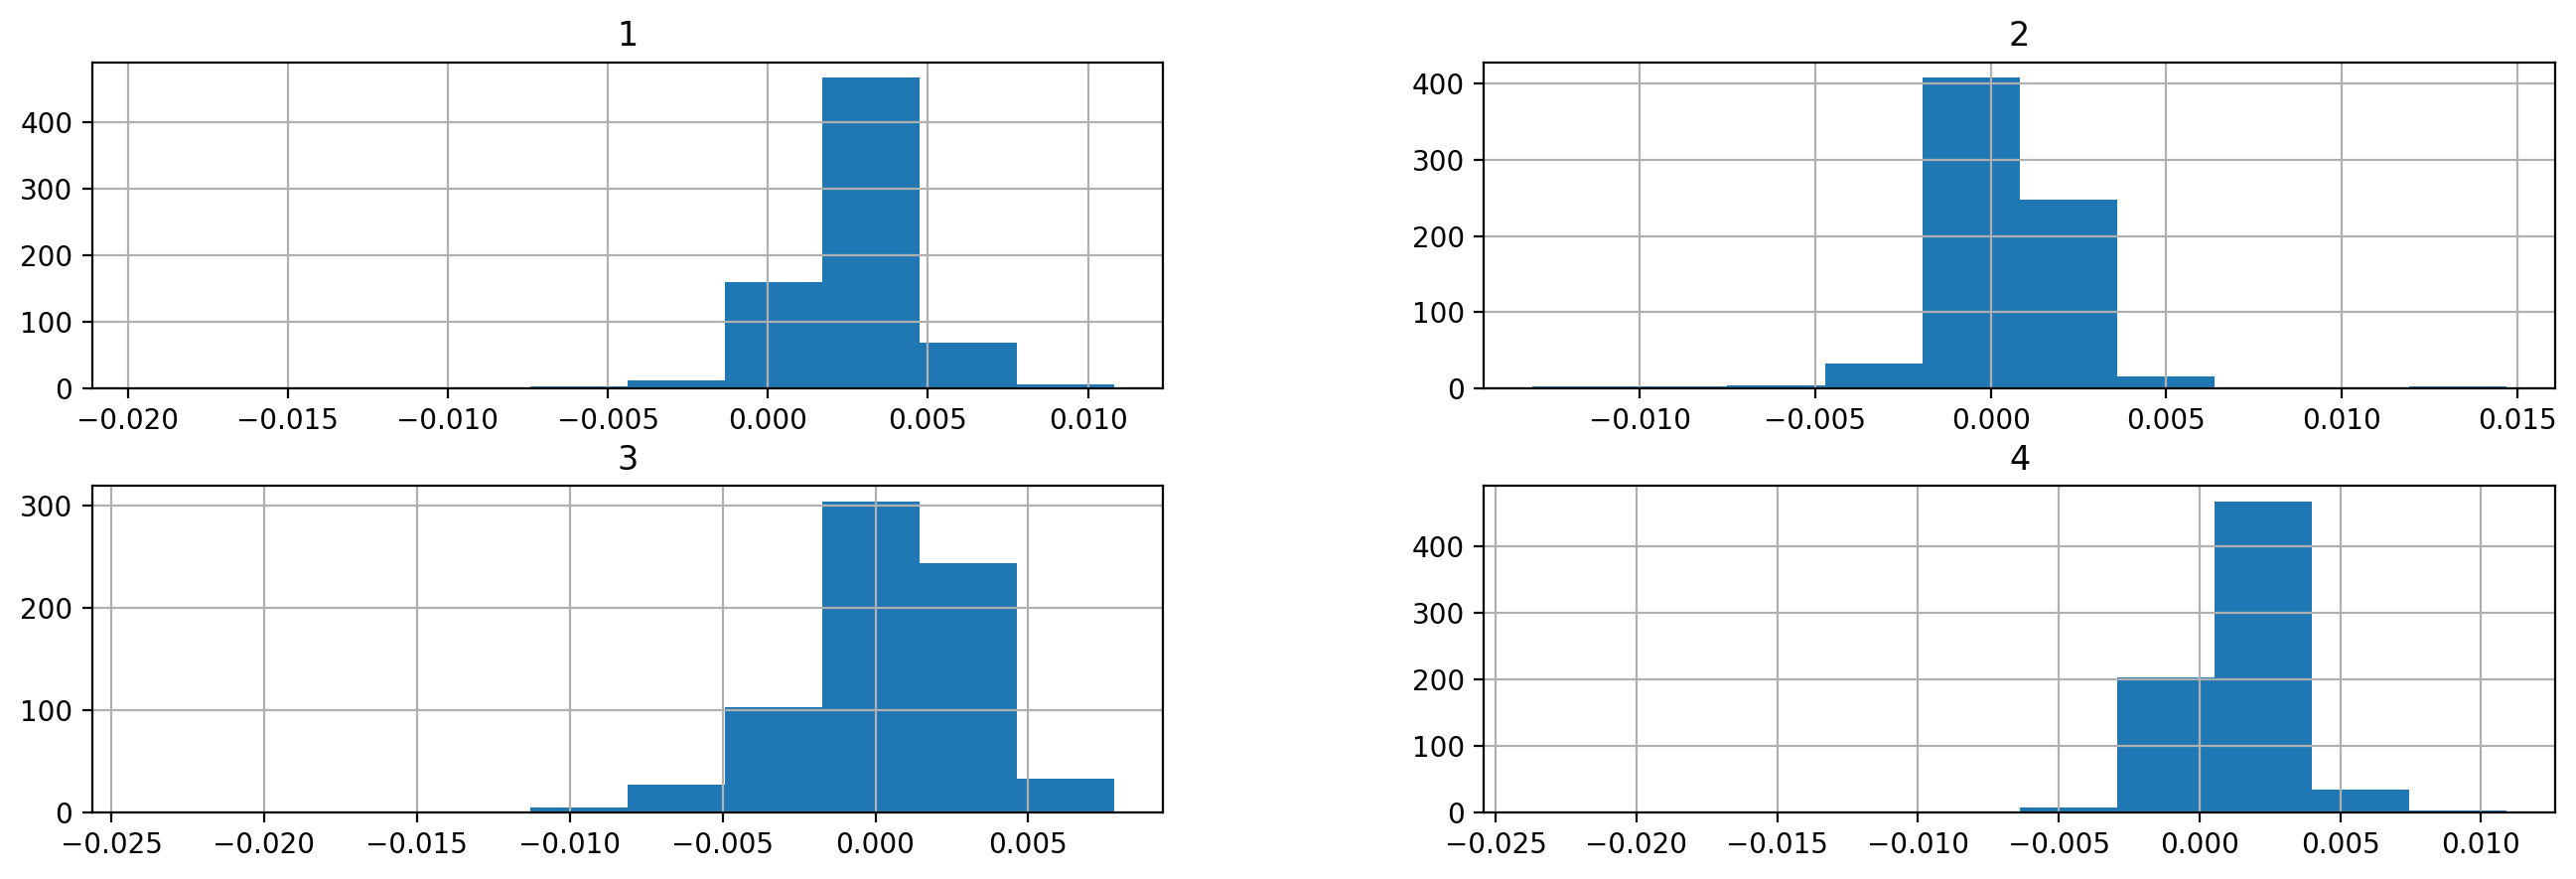

In [68]:
# Mo63 W1 Se1 S126	716	1
public[public['formula'] == 'Mo63 W1 Se1 S126'].iloc[:, -4:].hist();